### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 600
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 35  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [00:59<81:59:22, 59.04s/it]

Entrenando:   0%|          | 2/5000 [02:01<84:53:09, 61.14s/it]

Entrenando:   0%|          | 3/5000 [03:13<91:53:22, 66.20s/it]

Entrenando:   0%|          | 4/5000 [04:32<98:47:06, 71.18s/it]

Entrenando:   0%|          | 5/5000 [05:43<98:43:09, 71.15s/it]

Entrenando:   0%|          | 6/5000 [06:49<96:00:09, 69.21s/it]

Entrenando:   0%|          | 7/5000 [08:01<97:10:10, 70.06s/it]

Entrenando:   0%|          | 8/5000 [09:14<98:46:43, 71.23s/it]

Entrenando:   0%|          | 9/5000 [10:32<101:30:46, 73.22s/it]

Entrenando:   0%|          | 10/5000 [11:38<98:20:16, 70.95s/it]

Entrenando:   0%|          | 11/5000 [12:49<98:22:34, 70.99s/it]

Entrenando:   0%|          | 12/5000 [14:04<100:04:17, 72.22s/it]

Entrenando:   0%|          | 13/5000 [15:18<100:40:50, 72.68s/it]

Entrenando:   0%|          | 14/5000 [16:53<110:01:27, 79.44s/it]

Entrenando:   0%|          | 15/5000 [18:53<126:53:43, 91.64s/it]

Entrenando:   0%|          | 16/5000 [20:38<132:35:40, 95.77s/it]

Entrenando:   0%|          | 17/5000 [22:35<141:36:04, 102.30s/it]

Entrenando:   0%|          | 18/5000 [24:22<143:28:22, 103.67s/it]

Entrenando:   0%|          | 19/5000 [26:18<148:20:10, 107.21s/it]

Entrenando:   0%|          | 20/5000 [28:11<150:55:13, 109.10s/it]

Entrenando:   0%|          | 21/5000 [30:05<152:53:52, 110.55s/it]

Entrenando:   0%|          | 22/5000 [31:49<150:05:09, 108.54s/it]

Entrenando:   0%|          | 23/5000 [33:45<153:06:17, 110.74s/it]

Entrenando:   0%|          | 24/5000 [35:39<154:38:16, 111.88s/it]

Entrenando:   0%|          | 25/5000 [37:23<151:04:57, 109.33s/it]

Entrenando:   1%|          | 26/5000 [39:41<163:09:35, 118.09s/it]

Entrenando:   1%|          | 27/5000 [42:08<175:08:08, 126.78s/it]

Entrenando:   1%|          | 28/5000 [44:37<184:09:49, 133.34s/it]

Entrenando:   1%|          | 29/5000 [46:56<186:34:04, 135.11s/it]

Entrenando:   1%|          | 30/5000 [49:15<187:53:56, 136.10s/it]

Entrenando:   1%|          | 31/5000 [51:33<188:34:03, 136.62s/it]

Entrenando:   1%|          | 32/5000 [53:50<188:59:09, 136.95s/it]

Entrenando:   1%|          | 33/5000 [56:10<190:14:27, 137.88s/it]

Entrenando:   1%|          | 34/5000 [58:26<189:11:21, 137.15s/it]

Entrenando:   1%|          | 35/5000 [1:00:47<190:39:05, 138.24s/it]

Entrenando:   1%|          | 36/5000 [1:03:04<190:28:12, 138.13s/it]

Entrenando:   1%|          | 37/5000 [1:05:25<191:18:44, 138.77s/it]

Entrenando:   1%|          | 38/5000 [1:07:43<191:16:54, 138.78s/it]

Entrenando:   1%|          | 39/5000 [1:10:05<192:34:48, 139.75s/it]

Entrenando:   1%|          | 40/5000 [1:12:27<193:14:58, 140.26s/it]

Entrenando:   1%|          | 41/5000 [1:14:49<193:45:53, 140.66s/it]

Entrenando:   1%|          | 42/5000 [1:17:13<195:21:05, 141.84s/it]

Entrenando:   1%|          | 43/5000 [1:19:43<198:30:24, 144.16s/it]

Entrenando:   1%|          | 44/5000 [1:22:05<197:48:37, 143.69s/it]

Entrenando:   1%|          | 45/5000 [1:24:31<198:47:19, 144.43s/it]

Entrenando:   1%|          | 46/5000 [1:26:58<199:35:00, 145.03s/it]

Entrenando:   1%|          | 47/5000 [1:29:15<196:07:17, 142.55s/it]

Entrenando:   1%|          | 48/5000 [1:31:22<189:40:00, 137.88s/it]

Entrenando:   1%|          | 49/5000 [1:33:24<183:05:49, 133.13s/it]

Entrenando:   1%|          | 50/5000 [1:35:19<175:54:28, 127.93s/it]

Iter  50: train_loss=8.2304, val_loss=7.6681, train_suc=0.355, train_err=0.177, train_inc=0.468 | val_suc=0.373, val_err=0.175, val_inc=0.451


Entrenando:   1%|          | 51/5000 [1:37:09<168:28:05, 122.55s/it]

Entrenando:   1%|          | 52/5000 [1:39:07<166:28:43, 121.12s/it]

Entrenando:   1%|          | 53/5000 [1:40:56<161:20:59, 117.42s/it]

Entrenando:   1%|          | 54/5000 [1:42:51<160:15:32, 116.65s/it]

Entrenando:   1%|          | 55/5000 [1:44:54<162:50:02, 118.54s/it]

Entrenando:   1%|          | 56/5000 [1:46:44<159:28:01, 116.12s/it]

Entrenando:   1%|          | 57/5000 [1:48:41<159:42:15, 116.31s/it]

Entrenando:   1%|          | 58/5000 [1:50:25<154:33:45, 112.59s/it]

Entrenando:   1%|          | 59/5000 [1:52:13<152:40:32, 111.24s/it]

Entrenando:   1%|          | 60/5000 [1:53:49<146:18:52, 106.63s/it]

Entrenando:   1%|          | 61/5000 [1:55:36<146:28:33, 106.77s/it]

Entrenando:   1%|          | 62/5000 [1:57:24<146:49:54, 107.05s/it]

Entrenando:   1%|▏         | 63/5000 [1:59:25<152:50:11, 111.45s/it]

Entrenando:   1%|▏         | 64/5000 [2:01:25<156:17:53, 113.99s/it]

Entrenando:   1%|▏         | 65/5000 [2:03:08<151:44:22, 110.69s/it]

Entrenando:   1%|▏         | 66/5000 [2:05:00<151:53:31, 110.83s/it]

Entrenando:   1%|▏         | 67/5000 [2:06:48<150:43:24, 109.99s/it]

Entrenando:   1%|▏         | 68/5000 [2:08:26<146:02:49, 106.60s/it]

Entrenando:   1%|▏         | 69/5000 [2:10:14<146:40:03, 107.08s/it]

Entrenando:   1%|▏         | 70/5000 [2:12:01<146:27:19, 106.95s/it]

Entrenando:   1%|▏         | 71/5000 [2:13:38<142:08:28, 103.82s/it]

Entrenando:   1%|▏         | 72/5000 [2:15:13<138:31:44, 101.20s/it]

Entrenando:   1%|▏         | 73/5000 [2:16:47<135:35:35, 99.07s/it] 

Entrenando:   1%|▏         | 74/5000 [2:18:20<133:09:21, 97.31s/it]

Entrenando:   2%|▏         | 75/5000 [2:19:53<131:18:47, 95.99s/it]

Entrenando:   2%|▏         | 76/5000 [2:21:27<130:21:51, 95.31s/it]

Entrenando:   2%|▏         | 77/5000 [2:22:59<129:16:50, 94.54s/it]

Entrenando:   2%|▏         | 78/5000 [2:24:33<128:52:29, 94.26s/it]

Entrenando:   2%|▏         | 79/5000 [2:26:05<128:00:53, 93.65s/it]

Entrenando:   2%|▏         | 80/5000 [2:27:38<127:34:10, 93.34s/it]

Entrenando:   2%|▏         | 81/5000 [2:29:03<124:20:30, 91.00s/it]

Entrenando:   2%|▏         | 82/5000 [2:30:28<121:32:20, 88.97s/it]

Entrenando:   2%|▏         | 83/5000 [2:31:52<119:34:15, 87.54s/it]

Entrenando:   2%|▏         | 84/5000 [2:33:14<117:10:33, 85.81s/it]

Entrenando:   2%|▏         | 85/5000 [2:34:35<115:26:15, 84.55s/it]

Entrenando:   2%|▏         | 86/5000 [2:35:56<113:44:45, 83.33s/it]

Entrenando:   2%|▏         | 87/5000 [2:37:19<113:40:27, 83.29s/it]

Entrenando:   2%|▏         | 88/5000 [2:38:35<110:36:48, 81.07s/it]

Entrenando:   2%|▏         | 89/5000 [2:39:55<110:17:20, 80.85s/it]

Entrenando:   2%|▏         | 90/5000 [2:41:12<108:38:54, 79.66s/it]

Entrenando:   2%|▏         | 91/5000 [2:42:21<104:11:11, 76.40s/it]

Entrenando:   2%|▏         | 92/5000 [2:43:42<106:09:18, 77.86s/it]

Entrenando:   2%|▏         | 93/5000 [2:44:51<102:28:34, 75.18s/it]

Entrenando:   2%|▏         | 94/5000 [2:46:00<100:04:20, 73.43s/it]

Entrenando:   2%|▏         | 95/5000 [2:47:25<104:39:27, 76.81s/it]

Entrenando:   2%|▏         | 96/5000 [2:48:36<102:23:46, 75.17s/it]

Entrenando:   2%|▏         | 97/5000 [2:49:45<99:51:04, 73.32s/it] 

Entrenando:   2%|▏         | 98/5000 [2:51:02<101:10:57, 74.31s/it]

Entrenando:   2%|▏         | 99/5000 [2:52:17<101:20:24, 74.44s/it]

Entrenando:   2%|▏         | 100/5000 [2:53:30<100:41:51, 73.98s/it]

Iter 100: train_loss=2.9800, val_loss=2.9138, train_suc=0.413, train_err=0.036, train_inc=0.551 | val_suc=0.432, val_err=0.037, val_inc=0.531
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [2:54:41<99:39:45, 73.24s/it] 

Entrenando:   2%|▏         | 102/5000 [2:55:56<100:11:48, 73.64s/it]

Entrenando:   2%|▏         | 103/5000 [2:57:04<98:05:00, 72.11s/it] 

Entrenando:   2%|▏         | 104/5000 [2:58:14<97:10:06, 71.45s/it]

Entrenando:   2%|▏         | 105/5000 [2:59:23<96:08:34, 70.71s/it]

Entrenando:   2%|▏         | 106/5000 [3:00:40<98:49:34, 72.70s/it]

Entrenando:   2%|▏         | 107/5000 [3:02:02<102:17:13, 75.26s/it]

Entrenando:   2%|▏         | 108/5000 [3:03:14<101:13:34, 74.49s/it]

Entrenando:   2%|▏         | 109/5000 [3:04:18<96:57:33, 71.37s/it] 

Entrenando:   2%|▏         | 110/5000 [3:05:26<95:12:53, 70.10s/it]

Entrenando:   2%|▏         | 111/5000 [3:06:40<97:02:26, 71.46s/it]

Entrenando:   2%|▏         | 112/5000 [3:07:44<93:46:49, 69.07s/it]

Entrenando:   2%|▏         | 113/5000 [3:08:50<92:38:02, 68.24s/it]

Entrenando:   2%|▏         | 114/5000 [3:10:05<95:32:24, 70.39s/it]

Entrenando:   2%|▏         | 115/5000 [3:11:17<95:48:47, 70.61s/it]

Entrenando:   2%|▏         | 116/5000 [3:12:24<94:28:32, 69.64s/it]

Entrenando:   2%|▏         | 117/5000 [3:13:32<93:50:36, 69.19s/it]

Entrenando:   2%|▏         | 118/5000 [3:14:52<98:22:47, 72.55s/it]

Entrenando:   2%|▏         | 119/5000 [3:16:13<101:45:13, 75.05s/it]

Entrenando:   2%|▏         | 120/5000 [3:17:19<97:48:50, 72.16s/it] 

Entrenando:   2%|▏         | 121/5000 [3:18:37<100:21:47, 74.05s/it]

Entrenando:   2%|▏         | 122/5000 [3:19:42<96:32:04, 71.24s/it] 

Entrenando:   2%|▏         | 123/5000 [3:20:55<97:10:48, 71.73s/it]

Entrenando:   2%|▏         | 124/5000 [3:22:08<97:40:35, 72.12s/it]

Entrenando:   2%|▎         | 125/5000 [3:23:25<99:48:51, 73.71s/it]

Entrenando:   3%|▎         | 126/5000 [3:24:35<98:02:34, 72.42s/it]

Entrenando:   3%|▎         | 127/5000 [3:25:44<96:39:03, 71.40s/it]

Entrenando:   3%|▎         | 128/5000 [3:26:59<98:12:53, 72.57s/it]

Entrenando:   3%|▎         | 129/5000 [3:28:17<100:28:08, 74.25s/it]

Entrenando:   3%|▎         | 130/5000 [3:29:30<99:56:39, 73.88s/it] 

Entrenando:   3%|▎         | 131/5000 [3:30:43<99:38:31, 73.67s/it]

Entrenando:   3%|▎         | 132/5000 [3:32:02<101:30:56, 75.07s/it]

Entrenando:   3%|▎         | 133/5000 [3:33:19<102:19:27, 75.69s/it]

Entrenando:   3%|▎         | 134/5000 [3:34:33<101:38:41, 75.20s/it]

Entrenando:   3%|▎         | 135/5000 [3:35:40<98:16:18, 72.72s/it] 

Entrenando:   3%|▎         | 136/5000 [3:36:59<100:49:55, 74.63s/it]

Entrenando:   3%|▎         | 137/5000 [3:38:11<99:38:48, 73.77s/it] 

Entrenando:   3%|▎         | 138/5000 [3:39:24<99:22:51, 73.59s/it]

Entrenando:   3%|▎         | 139/5000 [3:40:34<97:52:48, 72.49s/it]

Entrenando:   3%|▎         | 140/5000 [3:41:52<100:13:05, 74.24s/it]

Entrenando:   3%|▎         | 141/5000 [3:43:07<100:36:36, 74.54s/it]

Entrenando:   3%|▎         | 142/5000 [3:44:20<99:52:58, 74.02s/it] 

Entrenando:   3%|▎         | 143/5000 [3:45:30<98:05:12, 72.70s/it]

Entrenando:   3%|▎         | 144/5000 [3:46:50<101:06:59, 74.96s/it]

Entrenando:   3%|▎         | 145/5000 [3:48:09<102:32:27, 76.03s/it]

Entrenando:   3%|▎         | 146/5000 [3:49:21<100:57:38, 74.88s/it]

Entrenando:   3%|▎         | 147/5000 [3:50:34<100:19:14, 74.42s/it]

Entrenando:   3%|▎         | 148/5000 [3:51:47<99:32:19, 73.85s/it] 

Entrenando:   3%|▎         | 149/5000 [3:53:02<100:18:48, 74.44s/it]

Entrenando:   3%|▎         | 150/5000 [3:54:16<100:06:54, 74.31s/it]

Iter 150: train_loss=1.8719, val_loss=1.7607, train_suc=0.441, train_err=0.004, train_inc=0.555 | val_suc=0.461, val_err=0.004, val_inc=0.535


Entrenando:   3%|▎         | 151/5000 [3:55:26<98:02:58, 72.79s/it] 

Entrenando:   3%|▎         | 152/5000 [3:56:44<100:26:05, 74.58s/it]

Entrenando:   3%|▎         | 153/5000 [3:57:54<98:27:14, 73.12s/it] 

Entrenando:   3%|▎         | 154/5000 [3:59:07<98:22:31, 73.08s/it]

Entrenando:   3%|▎         | 155/5000 [4:00:11<94:48:47, 70.45s/it]

Entrenando:   3%|▎         | 156/5000 [4:01:18<93:19:32, 69.36s/it]

Entrenando:   3%|▎         | 157/5000 [4:02:34<95:45:15, 71.18s/it]

Entrenando:   3%|▎         | 158/5000 [4:03:45<95:57:33, 71.35s/it]

Entrenando:   3%|▎         | 159/5000 [4:04:58<96:23:12, 71.68s/it]

Entrenando:   3%|▎         | 160/5000 [4:06:06<94:54:47, 70.60s/it]

Entrenando:   3%|▎         | 161/5000 [4:07:11<92:50:26, 69.07s/it]

Entrenando:   3%|▎         | 162/5000 [4:08:21<92:59:06, 69.19s/it]

Entrenando:   3%|▎         | 163/5000 [4:09:32<93:47:54, 69.81s/it]

Entrenando:   3%|▎         | 164/5000 [4:10:44<94:38:06, 70.45s/it]

Entrenando:   3%|▎         | 165/5000 [4:12:00<96:40:26, 71.98s/it]

Entrenando:   3%|▎         | 166/5000 [4:13:11<96:18:18, 71.72s/it]

Entrenando:   3%|▎         | 167/5000 [4:14:20<95:11:54, 70.91s/it]

Entrenando:   3%|▎         | 168/5000 [4:15:30<94:47:42, 70.63s/it]

Entrenando:   3%|▎         | 169/5000 [4:16:35<92:42:43, 69.09s/it]

Entrenando:   3%|▎         | 170/5000 [4:17:50<94:52:32, 70.71s/it]

Entrenando:   3%|▎         | 171/5000 [4:18:58<93:59:20, 70.07s/it]

Entrenando:   3%|▎         | 172/5000 [4:20:13<95:59:59, 71.58s/it]

Entrenando:   3%|▎         | 173/5000 [4:21:20<93:51:53, 70.00s/it]

Entrenando:   3%|▎         | 174/5000 [4:22:28<92:59:05, 69.36s/it]

Entrenando:   4%|▎         | 175/5000 [4:23:37<92:56:55, 69.35s/it]

Entrenando:   4%|▎         | 176/5000 [4:24:50<94:22:13, 70.43s/it]

Entrenando:   4%|▎         | 177/5000 [4:26:04<95:47:02, 71.50s/it]

Entrenando:   4%|▎         | 178/5000 [4:27:14<95:12:43, 71.08s/it]

Entrenando:   4%|▎         | 179/5000 [4:28:27<95:52:35, 71.59s/it]

Entrenando:   4%|▎         | 180/5000 [4:29:35<94:31:20, 70.60s/it]

Entrenando:   4%|▎         | 181/5000 [4:30:45<94:22:57, 70.51s/it]

Entrenando:   4%|▎         | 182/5000 [4:31:56<94:33:18, 70.65s/it]

Entrenando:   4%|▎         | 183/5000 [4:33:16<98:02:11, 73.27s/it]

Entrenando:   4%|▎         | 184/5000 [4:34:32<99:20:37, 74.26s/it]

Entrenando:   4%|▎         | 185/5000 [4:35:44<98:26:12, 73.60s/it]

Entrenando:   4%|▎         | 186/5000 [4:37:00<99:25:54, 74.36s/it]

Entrenando:   4%|▎         | 187/5000 [4:38:12<98:10:31, 73.43s/it]

Entrenando:   4%|▍         | 188/5000 [4:39:28<99:24:09, 74.37s/it]

Entrenando:   4%|▍         | 189/5000 [4:40:43<99:39:48, 74.58s/it]

Entrenando:   4%|▍         | 190/5000 [4:41:56<98:56:59, 74.06s/it]

Entrenando:   4%|▍         | 191/5000 [4:43:04<96:24:11, 72.17s/it]

Entrenando:   4%|▍         | 192/5000 [4:44:08<93:00:48, 69.64s/it]

Entrenando:   4%|▍         | 193/5000 [4:45:18<93:19:27, 69.89s/it]

Entrenando:   4%|▍         | 194/5000 [4:46:33<95:09:11, 71.28s/it]

Entrenando:   4%|▍         | 195/5000 [4:47:41<94:04:18, 70.48s/it]

Entrenando:   4%|▍         | 196/5000 [4:48:50<93:23:04, 69.98s/it]

Entrenando:   4%|▍         | 197/5000 [4:49:59<92:51:29, 69.60s/it]

Entrenando:   4%|▍         | 198/5000 [4:51:11<94:02:53, 70.51s/it]

Entrenando:   4%|▍         | 199/5000 [4:52:24<94:50:00, 71.11s/it]

Entrenando:   4%|▍         | 200/5000 [4:53:36<95:22:29, 71.53s/it]

Iter 200: train_loss=1.5945, val_loss=1.6307, train_suc=0.444, train_err=0.001, train_inc=0.555 | val_suc=0.464, val_err=0.001, val_inc=0.535
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [4:54:54<97:50:34, 73.40s/it]

Entrenando:   4%|▍         | 202/5000 [4:56:20<102:42:38, 77.07s/it]

Entrenando:   4%|▍         | 203/5000 [4:58:35<125:55:05, 94.50s/it]

Entrenando:   4%|▍         | 204/5000 [5:00:59<145:31:02, 109.23s/it]

Entrenando:   4%|▍         | 205/5000 [5:03:16<156:37:51, 117.60s/it]

Entrenando:   4%|▍         | 206/5000 [5:05:24<161:03:03, 120.94s/it]

Entrenando:   4%|▍         | 207/5000 [5:07:35<164:42:10, 123.71s/it]

Entrenando:   4%|▍         | 208/5000 [5:09:45<167:16:48, 125.67s/it]

Entrenando:   4%|▍         | 209/5000 [5:11:54<168:48:10, 126.84s/it]

Entrenando:   4%|▍         | 210/5000 [5:14:15<174:14:50, 130.96s/it]

Entrenando:   4%|▍         | 211/5000 [5:16:28<175:03:28, 131.60s/it]

Entrenando:   4%|▍         | 212/5000 [5:18:44<176:45:22, 132.90s/it]

Entrenando:   4%|▍         | 213/5000 [5:20:52<174:35:29, 131.30s/it]

Entrenando:   4%|▍         | 214/5000 [5:22:57<172:06:30, 129.46s/it]

Entrenando:   4%|▍         | 215/5000 [5:25:00<169:34:11, 127.58s/it]

Entrenando:   4%|▍         | 216/5000 [5:27:11<170:53:01, 128.59s/it]

Entrenando:   4%|▍         | 217/5000 [5:29:25<173:08:55, 130.32s/it]

Entrenando:   4%|▍         | 218/5000 [5:31:38<173:57:30, 130.96s/it]

Entrenando:   4%|▍         | 219/5000 [5:33:59<178:06:15, 134.11s/it]

Entrenando:   4%|▍         | 220/5000 [5:36:20<180:35:49, 136.01s/it]

Entrenando:   4%|▍         | 221/5000 [5:38:32<179:14:48, 135.03s/it]

Entrenando:   4%|▍         | 222/5000 [5:40:45<178:14:58, 134.30s/it]

Entrenando:   4%|▍         | 223/5000 [5:43:01<178:42:47, 134.68s/it]

Entrenando:   4%|▍         | 224/5000 [5:45:09<176:21:59, 132.94s/it]

Entrenando:   4%|▍         | 225/5000 [5:47:25<177:32:03, 133.85s/it]

Entrenando:   5%|▍         | 226/5000 [5:49:44<179:18:40, 135.22s/it]

Entrenando:   5%|▍         | 227/5000 [5:51:56<178:05:52, 134.33s/it]

Entrenando:   5%|▍         | 228/5000 [5:54:11<178:25:55, 134.61s/it]

Entrenando:   5%|▍         | 229/5000 [5:56:22<176:42:23, 133.34s/it]

Entrenando:   5%|▍         | 230/5000 [5:58:39<178:15:01, 134.53s/it]

Entrenando:   5%|▍         | 231/5000 [6:00:56<179:16:55, 135.34s/it]

Entrenando:   5%|▍         | 232/5000 [6:03:09<178:19:36, 134.64s/it]

Entrenando:   5%|▍         | 233/5000 [6:05:18<175:45:52, 132.74s/it]

Entrenando:   5%|▍         | 234/5000 [6:07:26<174:08:10, 131.53s/it]

Entrenando:   5%|▍         | 235/5000 [6:09:31<171:34:51, 129.63s/it]

Entrenando:   5%|▍         | 236/5000 [6:11:29<166:53:41, 126.12s/it]

Entrenando:   5%|▍         | 237/5000 [6:13:34<166:20:04, 125.72s/it]

Entrenando:   5%|▍         | 238/5000 [6:15:26<160:46:41, 121.55s/it]

Entrenando:   5%|▍         | 239/5000 [6:17:11<154:16:10, 116.65s/it]

Entrenando:   5%|▍         | 240/5000 [6:18:55<149:16:24, 112.90s/it]

Entrenando:   5%|▍         | 241/5000 [6:20:46<148:32:38, 112.37s/it]

Entrenando:   5%|▍         | 242/5000 [6:22:36<147:20:45, 111.49s/it]

Entrenando:   5%|▍         | 243/5000 [6:24:39<151:56:46, 114.99s/it]

Entrenando:   5%|▍         | 244/5000 [6:26:20<146:16:05, 110.72s/it]

Entrenando:   5%|▍         | 245/5000 [6:27:59<141:40:48, 107.27s/it]

Entrenando:   5%|▍         | 246/5000 [6:29:44<140:54:17, 106.70s/it]

Entrenando:   5%|▍         | 247/5000 [6:31:30<140:21:34, 106.31s/it]

Entrenando:   5%|▍         | 248/5000 [6:33:07<136:46:05, 103.61s/it]

Entrenando:   5%|▍         | 249/5000 [6:34:44<134:15:05, 101.73s/it]

Entrenando:   5%|▌         | 250/5000 [6:36:20<131:55:39, 99.99s/it] 

Iter 250: train_loss=1.5009, val_loss=1.6154, train_suc=0.444, train_err=0.000, train_inc=0.556 | val_suc=0.464, val_err=0.000, val_inc=0.536


Entrenando:   5%|▌         | 251/5000 [6:37:54<129:21:35, 98.06s/it]

Entrenando:   5%|▌         | 252/5000 [6:39:26<126:56:11, 96.25s/it]

Entrenando:   5%|▌         | 253/5000 [6:40:54<123:46:29, 93.87s/it]

Entrenando:   5%|▌         | 254/5000 [6:42:27<123:16:25, 93.51s/it]

Entrenando:   5%|▌         | 255/5000 [6:43:59<122:50:31, 93.20s/it]

Entrenando:   5%|▌         | 256/5000 [6:45:28<120:48:09, 91.67s/it]

Entrenando:   5%|▌         | 257/5000 [6:47:00<120:58:07, 91.82s/it]

Entrenando:   5%|▌         | 258/5000 [6:48:27<119:04:09, 90.39s/it]

Entrenando:   5%|▌         | 259/5000 [6:49:57<118:48:34, 90.22s/it]

Entrenando:   5%|▌         | 260/5000 [6:51:24<117:49:54, 89.49s/it]

Entrenando:   5%|▌         | 261/5000 [6:52:48<115:41:03, 87.88s/it]

Entrenando:   5%|▌         | 262/5000 [6:54:10<113:05:04, 85.92s/it]

Entrenando:   5%|▌         | 263/5000 [6:55:39<114:29:26, 87.01s/it]

Entrenando:   5%|▌         | 264/5000 [6:56:58<111:08:02, 84.48s/it]

Entrenando:   5%|▌         | 265/5000 [6:58:19<109:35:16, 83.32s/it]

Entrenando:   5%|▌         | 266/5000 [6:59:38<108:00:12, 82.13s/it]

Entrenando:   5%|▌         | 267/5000 [7:00:57<106:56:50, 81.35s/it]

Entrenando:   5%|▌         | 268/5000 [7:02:18<106:32:06, 81.05s/it]

Entrenando:   5%|▌         | 269/5000 [7:03:39<106:34:24, 81.10s/it]

Entrenando:   5%|▌         | 270/5000 [7:04:55<104:21:13, 79.42s/it]

Entrenando:   5%|▌         | 271/5000 [7:06:12<103:41:55, 78.94s/it]

Entrenando:   5%|▌         | 272/5000 [7:07:30<103:19:21, 78.67s/it]

Entrenando:   5%|▌         | 273/5000 [7:08:42<100:26:37, 76.50s/it]

Entrenando:   5%|▌         | 274/5000 [7:09:52<97:49:29, 74.52s/it] 

Entrenando:   6%|▌         | 275/5000 [7:11:09<98:56:23, 75.38s/it]

Entrenando:   6%|▌         | 276/5000 [7:12:25<99:00:22, 75.45s/it]

Entrenando:   6%|▌         | 277/5000 [7:13:37<97:40:41, 74.45s/it]

Entrenando:   6%|▌         | 278/5000 [7:14:50<97:07:56, 74.05s/it]

Entrenando:   6%|▌         | 279/5000 [7:16:02<96:16:02, 73.41s/it]

Entrenando:   6%|▌         | 280/5000 [7:17:15<96:04:38, 73.28s/it]

Entrenando:   6%|▌         | 281/5000 [7:18:30<96:51:16, 73.89s/it]

Entrenando:   6%|▌         | 282/5000 [7:19:39<94:57:49, 72.46s/it]

Entrenando:   6%|▌         | 283/5000 [7:20:48<93:21:47, 71.25s/it]

Entrenando:   6%|▌         | 284/5000 [7:22:01<94:19:32, 72.00s/it]

Entrenando:   6%|▌         | 285/5000 [7:23:13<93:55:12, 71.71s/it]

Entrenando:   6%|▌         | 286/5000 [7:24:25<94:18:14, 72.02s/it]

Entrenando:   6%|▌         | 287/5000 [7:25:30<91:31:04, 69.91s/it]

Entrenando:   6%|▌         | 288/5000 [7:26:44<92:51:11, 70.94s/it]

Entrenando:   6%|▌         | 289/5000 [7:27:57<93:42:31, 71.61s/it]

Entrenando:   6%|▌         | 290/5000 [7:29:10<94:13:34, 72.02s/it]

Entrenando:   6%|▌         | 291/5000 [7:30:27<96:13:50, 73.57s/it]

Entrenando:   6%|▌         | 292/5000 [7:31:43<97:13:25, 74.34s/it]

Entrenando:   6%|▌         | 293/5000 [7:32:55<96:19:22, 73.67s/it]

Entrenando:   6%|▌         | 294/5000 [7:34:07<95:34:35, 73.11s/it]

Entrenando:   6%|▌         | 295/5000 [7:35:25<97:37:55, 74.70s/it]

Entrenando:   6%|▌         | 296/5000 [7:36:39<97:09:13, 74.35s/it]

Entrenando:   6%|▌         | 297/5000 [7:37:49<95:17:38, 72.94s/it]

Entrenando:   6%|▌         | 298/5000 [7:39:02<95:34:14, 73.17s/it]

Entrenando:   6%|▌         | 299/5000 [7:40:13<94:45:44, 72.57s/it]

Entrenando:   6%|▌         | 300/5000 [7:41:30<96:07:42, 73.63s/it]

Iter 300: train_loss=1.6840, val_loss=1.6128, train_suc=0.444, train_err=0.000, train_inc=0.556 | val_suc=0.464, val_err=0.000, val_inc=0.536
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [7:42:39<94:18:18, 72.25s/it]

Entrenando:   6%|▌         | 302/5000 [7:43:56<96:08:19, 73.67s/it]

Entrenando:   6%|▌         | 303/5000 [7:45:10<96:19:28, 73.83s/it]

Entrenando:   6%|▌         | 304/5000 [7:46:24<96:35:22, 74.05s/it]

Entrenando:   6%|▌         | 305/5000 [7:47:37<96:05:25, 73.68s/it]

Entrenando:   6%|▌         | 306/5000 [7:48:46<93:59:27, 72.09s/it]

Entrenando:   6%|▌         | 307/5000 [7:49:59<94:39:13, 72.61s/it]

Entrenando:   6%|▌         | 308/5000 [7:51:15<96:01:04, 73.67s/it]

Entrenando:   6%|▌         | 309/5000 [7:52:33<97:36:36, 74.91s/it]

Entrenando:   6%|▌         | 310/5000 [7:53:48<97:30:27, 74.85s/it]

Entrenando:   6%|▌         | 311/5000 [7:55:02<97:11:26, 74.62s/it]

Entrenando:   6%|▌         | 312/5000 [7:56:12<95:25:34, 73.28s/it]

Entrenando:   6%|▋         | 313/5000 [7:57:31<97:31:21, 74.91s/it]

Entrenando:   6%|▋         | 314/5000 [7:58:40<95:15:26, 73.18s/it]

Entrenando:   6%|▋         | 315/5000 [7:59:46<92:32:22, 71.11s/it]

Entrenando:   6%|▋         | 316/5000 [8:01:01<93:43:25, 72.03s/it]

Entrenando:   6%|▋         | 317/5000 [8:02:13<94:03:40, 72.31s/it]

Entrenando:   6%|▋         | 318/5000 [8:03:29<95:10:20, 73.18s/it]

Entrenando:   6%|▋         | 319/5000 [8:04:48<97:24:42, 74.92s/it]

Entrenando:   6%|▋         | 320/5000 [8:05:57<95:20:11, 73.34s/it]

Entrenando:   6%|▋         | 321/5000 [8:07:16<97:16:58, 74.85s/it]

Entrenando:   6%|▋         | 322/5000 [8:08:32<97:45:58, 75.24s/it]

Entrenando:   6%|▋         | 323/5000 [8:09:47<97:50:42, 75.31s/it]

Entrenando:   6%|▋         | 324/5000 [8:10:59<96:22:08, 74.19s/it]

Entrenando:   6%|▋         | 325/5000 [8:12:14<96:44:59, 74.50s/it]

Entrenando:   7%|▋         | 326/5000 [8:13:33<98:34:50, 75.93s/it]

Entrenando:   7%|▋         | 327/5000 [8:14:46<97:14:16, 74.91s/it]

Entrenando:   7%|▋         | 328/5000 [8:16:06<99:05:21, 76.35s/it]

Entrenando:   7%|▋         | 329/5000 [8:17:11<94:51:29, 73.11s/it]

Entrenando:   7%|▋         | 330/5000 [8:18:16<91:46:32, 70.75s/it]

Entrenando:   7%|▋         | 331/5000 [8:19:22<89:33:41, 69.06s/it]

Entrenando:   7%|▋         | 332/5000 [8:20:34<91:02:47, 70.22s/it]

Entrenando:   7%|▋         | 333/5000 [8:21:46<91:44:08, 70.76s/it]

Entrenando:   7%|▋         | 334/5000 [8:23:03<94:08:12, 72.63s/it]

Entrenando:   7%|▋         | 335/5000 [8:24:22<96:19:05, 74.33s/it]

Entrenando:   7%|▋         | 336/5000 [8:26:05<107:24:49, 82.91s/it]

Entrenando:   7%|▋         | 337/5000 [8:27:57<118:45:27, 91.69s/it]

Entrenando:   7%|▋         | 338/5000 [8:29:54<128:31:49, 99.25s/it]

Entrenando:   7%|▋         | 339/5000 [8:31:49<134:50:43, 104.15s/it]

Entrenando:   7%|▋         | 340/5000 [8:33:39<136:58:06, 105.81s/it]

Entrenando:   7%|▋         | 341/5000 [8:35:24<136:36:38, 105.56s/it]

Entrenando:   7%|▋         | 342/5000 [8:37:12<137:22:04, 106.17s/it]

Entrenando:   7%|▋         | 343/5000 [8:38:57<137:12:57, 106.07s/it]

Entrenando:   7%|▋         | 344/5000 [8:40:44<137:28:51, 106.30s/it]

Entrenando:   7%|▋         | 345/5000 [8:42:38<140:09:39, 108.40s/it]

Entrenando:   7%|▋         | 346/5000 [8:44:40<145:44:18, 112.73s/it]

Entrenando:   7%|▋         | 347/5000 [8:46:44<150:02:31, 116.09s/it]

Entrenando:   7%|▋         | 348/5000 [8:48:36<148:07:28, 114.63s/it]

Entrenando:   7%|▋         | 349/5000 [8:50:29<147:49:28, 114.42s/it]

Entrenando:   7%|▋         | 350/5000 [8:52:09<142:01:34, 109.96s/it]

Iter 350: train_loss=1.6681, val_loss=1.6119, train_suc=0.444, train_err=0.000, train_inc=0.556 | val_suc=0.463, val_err=0.000, val_inc=0.537


Entrenando:   7%|▋         | 351/5000 [8:54:08<145:31:57, 112.69s/it]

Entrenando:   7%|▋         | 352/5000 [8:56:02<146:01:15, 113.10s/it]

Entrenando:   7%|▋         | 353/5000 [8:58:01<148:15:57, 114.86s/it]

Entrenando:   7%|▋         | 354/5000 [9:00:04<151:25:46, 117.34s/it]

Entrenando:   7%|▋         | 355/5000 [9:01:50<146:59:55, 113.93s/it]

Entrenando:   7%|▋         | 356/5000 [9:03:55<151:21:31, 117.33s/it]

Entrenando:   7%|▋         | 357/5000 [9:05:43<147:32:27, 114.40s/it]

Entrenando:   7%|▋         | 358/5000 [9:07:41<149:03:38, 115.60s/it]

Entrenando:   7%|▋         | 359/5000 [9:09:27<145:14:45, 112.67s/it]

Entrenando:   7%|▋         | 360/5000 [9:11:18<144:16:23, 111.94s/it]

Entrenando:   7%|▋         | 361/5000 [9:13:06<142:45:03, 110.78s/it]

Entrenando:   7%|▋         | 362/5000 [9:15:02<144:57:31, 112.52s/it]

Entrenando:   7%|▋         | 363/5000 [9:16:54<144:46:28, 112.40s/it]

Entrenando:   7%|▋         | 364/5000 [9:18:47<144:50:19, 112.47s/it]

Entrenando:   7%|▋         | 365/5000 [9:20:29<140:45:31, 109.33s/it]

Entrenando:   7%|▋         | 366/5000 [9:22:31<145:43:27, 113.21s/it]

Entrenando:   7%|▋         | 367/5000 [9:24:16<142:31:40, 110.75s/it]

Entrenando:   7%|▋         | 368/5000 [9:26:01<140:05:38, 108.88s/it]

Entrenando:   7%|▋         | 369/5000 [9:27:51<140:36:37, 109.31s/it]

Entrenando:   7%|▋         | 370/5000 [9:29:39<140:06:25, 108.94s/it]

Entrenando:   7%|▋         | 371/5000 [9:31:24<138:31:59, 107.74s/it]

Entrenando:   7%|▋         | 372/5000 [9:33:15<139:42:37, 108.68s/it]

Entrenando:   7%|▋         | 373/5000 [9:35:08<141:28:43, 110.08s/it]

Entrenando:   7%|▋         | 374/5000 [9:37:02<142:58:02, 111.26s/it]

Entrenando:   8%|▊         | 375/5000 [9:39:00<145:29:10, 113.24s/it]

Entrenando:   8%|▊         | 376/5000 [9:40:47<143:00:52, 111.34s/it]

Entrenando:   8%|▊         | 377/5000 [9:42:38<142:56:58, 111.32s/it]

Entrenando:   8%|▊         | 378/5000 [9:44:31<143:26:28, 111.72s/it]

Entrenando:   8%|▊         | 379/5000 [9:46:28<145:22:19, 113.25s/it]

Entrenando:   8%|▊         | 380/5000 [9:48:21<145:11:07, 113.13s/it]

Entrenando:   8%|▊         | 381/5000 [9:50:18<146:43:11, 114.35s/it]

Entrenando:   8%|▊         | 382/5000 [9:52:18<149:05:55, 116.23s/it]

Entrenando:   8%|▊         | 383/5000 [9:54:06<145:53:50, 113.76s/it]

Entrenando:   8%|▊         | 384/5000 [9:56:06<148:15:17, 115.62s/it]

Entrenando:   8%|▊         | 385/5000 [9:57:58<146:44:10, 114.46s/it]

Entrenando:   8%|▊         | 386/5000 [9:59:54<147:05:27, 114.77s/it]

Entrenando:   8%|▊         | 387/5000 [10:01:42<144:37:45, 112.87s/it]

Entrenando:   8%|▊         | 388/5000 [10:03:41<146:50:03, 114.61s/it]

Entrenando:   8%|▊         | 389/5000 [10:05:23<142:07:47, 110.97s/it]

Entrenando:   8%|▊         | 390/5000 [10:07:18<143:29:38, 112.06s/it]

Entrenando:   8%|▊         | 391/5000 [10:09:08<142:38:01, 111.41s/it]

Entrenando:   8%|▊         | 392/5000 [10:10:56<141:27:57, 110.52s/it]

Entrenando:   8%|▊         | 393/5000 [10:12:49<142:24:22, 111.28s/it]

Entrenando:   8%|▊         | 394/5000 [10:14:37<141:05:26, 110.28s/it]

Entrenando:   8%|▊         | 395/5000 [10:16:24<139:52:56, 109.35s/it]

Entrenando:   8%|▊         | 396/5000 [10:18:09<138:01:18, 107.92s/it]

Entrenando:   8%|▊         | 397/5000 [10:19:54<136:53:13, 107.06s/it]

Entrenando:   8%|▊         | 398/5000 [10:21:41<137:01:35, 107.19s/it]

Entrenando:   8%|▊         | 399/5000 [10:23:34<138:52:35, 108.66s/it]

Entrenando:   8%|▊         | 400/5000 [10:25:17<136:50:44, 107.10s/it]

Iter 400: train_loss=1.6963, val_loss=1.6113, train_suc=0.444, train_err=0.000, train_inc=0.556 | val_suc=0.463, val_err=0.000, val_inc=0.536
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [10:27:15<141:04:58, 110.44s/it]

Entrenando:   8%|▊         | 402/5000 [10:29:01<139:12:27, 108.99s/it]

Entrenando:   8%|▊         | 403/5000 [10:31:03<144:12:55, 112.94s/it]

Entrenando:   8%|▊         | 404/5000 [10:32:57<144:37:49, 113.29s/it]

Entrenando:   8%|▊         | 405/5000 [10:34:56<146:51:01, 115.05s/it]

Entrenando:   8%|▊         | 406/5000 [10:36:39<141:58:40, 111.26s/it]

Entrenando:   8%|▊         | 407/5000 [10:38:29<141:46:04, 111.12s/it]

Entrenando:   8%|▊         | 408/5000 [10:40:12<138:22:00, 108.48s/it]

Entrenando:   8%|▊         | 409/5000 [10:42:03<139:16:28, 109.21s/it]

Entrenando:   8%|▊         | 410/5000 [10:43:57<141:22:19, 110.88s/it]

Entrenando:   8%|▊         | 411/5000 [10:45:46<140:21:27, 110.11s/it]

Entrenando:   8%|▊         | 412/5000 [10:47:38<141:04:06, 110.69s/it]

Entrenando:   8%|▊         | 413/5000 [10:49:19<137:34:43, 107.98s/it]

Entrenando:   8%|▊         | 414/5000 [10:51:06<136:52:23, 107.45s/it]

Entrenando:   8%|▊         | 415/5000 [10:52:53<136:38:21, 107.29s/it]

Entrenando:   8%|▊         | 416/5000 [10:54:47<139:16:45, 109.38s/it]

Entrenando:   8%|▊         | 417/5000 [10:56:41<140:55:54, 110.70s/it]

Entrenando:   8%|▊         | 418/5000 [10:58:31<140:38:46, 110.50s/it]

Entrenando:   8%|▊         | 419/5000 [11:00:13<137:19:29, 107.92s/it]

Entrenando:   8%|▊         | 420/5000 [11:02:10<141:02:00, 110.86s/it]

Entrenando:   8%|▊         | 421/5000 [11:04:06<142:40:33, 112.17s/it]

Entrenando:   8%|▊         | 422/5000 [11:05:46<138:04:09, 108.57s/it]

Entrenando:   8%|▊         | 423/5000 [11:07:39<139:57:17, 110.08s/it]

Entrenando:   8%|▊         | 424/5000 [11:09:35<141:53:41, 111.63s/it]

Entrenando:   8%|▊         | 425/5000 [11:11:25<141:33:32, 111.39s/it]

Entrenando:   9%|▊         | 426/5000 [11:13:11<139:13:43, 109.58s/it]

Entrenando:   9%|▊         | 427/5000 [11:15:03<140:04:44, 110.27s/it]

Entrenando:   9%|▊         | 428/5000 [11:16:59<142:30:08, 112.21s/it]

Entrenando:   9%|▊         | 429/5000 [11:19:02<146:29:29, 115.37s/it]

Entrenando:   9%|▊         | 430/5000 [11:20:55<145:24:44, 114.55s/it]

Entrenando:   9%|▊         | 431/5000 [11:22:47<144:24:48, 113.79s/it]

Entrenando:   9%|▊         | 432/5000 [11:24:41<144:22:53, 113.79s/it]

Entrenando:   9%|▊         | 433/5000 [11:26:35<144:42:11, 114.06s/it]

Entrenando:   9%|▊         | 434/5000 [11:28:22<141:53:22, 111.87s/it]

Entrenando:   9%|▊         | 435/5000 [11:30:07<139:12:12, 109.78s/it]

Entrenando:   9%|▊         | 436/5000 [11:32:00<140:21:40, 110.71s/it]

Entrenando:   9%|▊         | 437/5000 [11:33:50<140:07:06, 110.55s/it]

Entrenando:   9%|▉         | 438/5000 [11:35:51<143:59:53, 113.63s/it]

Entrenando:   9%|▉         | 439/5000 [11:37:39<142:00:50, 112.09s/it]

Entrenando:   9%|▉         | 440/5000 [11:39:26<139:58:56, 110.51s/it]

Entrenando:   9%|▉         | 441/5000 [11:41:13<138:33:49, 109.42s/it]

Entrenando:   9%|▉         | 442/5000 [11:42:58<136:58:58, 108.19s/it]

Entrenando:   9%|▉         | 443/5000 [11:44:51<138:37:42, 109.52s/it]

Entrenando:   9%|▉         | 444/5000 [11:47:03<147:02:04, 116.18s/it]

Entrenando:   9%|▉         | 445/5000 [11:49:00<147:29:09, 116.56s/it]

Entrenando:   9%|▉         | 446/5000 [11:50:53<145:52:47, 115.32s/it]

Entrenando:   9%|▉         | 447/5000 [11:52:43<144:04:07, 113.91s/it]

Entrenando:   9%|▉         | 448/5000 [11:54:39<144:50:02, 114.54s/it]

Entrenando:   9%|▉         | 449/5000 [11:56:24<141:06:48, 111.63s/it]

Entrenando:   9%|▉         | 450/5000 [11:58:10<138:54:35, 109.91s/it]

Iter 450: train_loss=1.6235, val_loss=1.6099, train_suc=0.444, train_err=0.000, train_inc=0.556 | val_suc=0.464, val_err=0.000, val_inc=0.536


Entrenando:   9%|▉         | 451/5000 [11:59:53<136:23:45, 107.94s/it]

Entrenando:   9%|▉         | 452/5000 [12:01:32<132:54:58, 105.21s/it]

Entrenando:   9%|▉         | 453/5000 [12:03:17<132:54:25, 105.23s/it]

Entrenando:   9%|▉         | 454/5000 [12:05:16<137:59:27, 109.28s/it]

Entrenando:   9%|▉         | 455/5000 [12:07:10<139:54:44, 110.82s/it]

Entrenando:   9%|▉         | 456/5000 [12:09:08<142:16:13, 112.71s/it]

Entrenando:   9%|▉         | 457/5000 [12:10:53<139:24:28, 110.47s/it]

Entrenando:   9%|▉         | 458/5000 [12:12:35<136:16:41, 108.01s/it]

Entrenando:   9%|▉         | 459/5000 [12:14:16<133:22:11, 105.73s/it]

Entrenando:   9%|▉         | 460/5000 [12:15:59<132:25:01, 105.00s/it]

Entrenando:   9%|▉         | 461/5000 [12:17:39<130:36:22, 103.59s/it]

Entrenando:   9%|▉         | 462/5000 [12:19:24<130:55:33, 103.86s/it]

Entrenando:   9%|▉         | 463/5000 [12:21:05<129:47:34, 102.99s/it]

Entrenando:   9%|▉         | 464/5000 [12:22:52<131:14:58, 104.17s/it]

Entrenando:   9%|▉         | 465/5000 [12:24:37<131:51:48, 104.68s/it]

Entrenando:   9%|▉         | 466/5000 [12:26:34<136:18:43, 108.23s/it]

Entrenando:   9%|▉         | 467/5000 [12:28:32<139:59:01, 111.17s/it]

Entrenando:   9%|▉         | 468/5000 [12:30:29<142:07:52, 112.90s/it]

Entrenando:   9%|▉         | 469/5000 [12:32:23<142:40:14, 113.36s/it]

Entrenando:   9%|▉         | 470/5000 [12:34:06<138:31:17, 110.08s/it]

Entrenando:   9%|▉         | 471/5000 [12:35:57<138:58:05, 110.46s/it]

Entrenando:   9%|▉         | 472/5000 [12:37:39<135:53:45, 108.04s/it]

Entrenando:   9%|▉         | 473/5000 [12:39:25<135:00:24, 107.36s/it]

Entrenando:   9%|▉         | 474/5000 [12:41:25<139:33:59, 111.01s/it]

Entrenando:  10%|▉         | 475/5000 [12:43:22<142:01:10, 112.99s/it]

Entrenando:  10%|▉         | 476/5000 [12:45:22<144:36:25, 115.07s/it]

Entrenando:  10%|▉         | 477/5000 [12:47:09<141:23:54, 112.54s/it]

Entrenando:  10%|▉         | 478/5000 [12:49:01<141:15:47, 112.46s/it]

Entrenando:  10%|▉         | 479/5000 [12:50:51<140:10:52, 111.62s/it]

Entrenando:  10%|▉         | 480/5000 [12:52:48<142:12:13, 113.26s/it]

Entrenando:  10%|▉         | 481/5000 [12:54:40<141:40:12, 112.86s/it]

Entrenando:  10%|▉         | 482/5000 [12:56:27<139:27:45, 111.13s/it]

Entrenando:  10%|▉         | 483/5000 [12:58:22<140:53:12, 112.29s/it]

Entrenando:  10%|▉         | 484/5000 [13:00:09<138:57:00, 110.77s/it]

Entrenando:  10%|▉         | 485/5000 [13:02:02<139:43:38, 111.41s/it]

Entrenando:  10%|▉         | 486/5000 [13:03:48<137:33:11, 109.70s/it]

Entrenando:  10%|▉         | 487/5000 [13:05:36<137:08:25, 109.40s/it]

Entrenando:  10%|▉         | 488/5000 [13:07:25<136:46:47, 109.13s/it]

Entrenando:  10%|▉         | 489/5000 [13:09:20<138:47:52, 110.77s/it]

Entrenando:  10%|▉         | 490/5000 [13:11:20<142:18:27, 113.59s/it]

Entrenando:  10%|▉         | 491/5000 [13:13:03<138:25:56, 110.52s/it]

Entrenando:  10%|▉         | 492/5000 [13:15:03<141:43:43, 113.18s/it]

Entrenando:  10%|▉         | 493/5000 [13:16:49<139:19:52, 111.29s/it]

Entrenando:  10%|▉         | 494/5000 [13:18:39<138:45:54, 110.86s/it]

Entrenando:  10%|▉         | 495/5000 [13:20:30<138:46:31, 110.90s/it]

Entrenando:  10%|▉         | 496/5000 [13:22:40<145:40:14, 116.43s/it]

Entrenando:  10%|▉         | 497/5000 [13:24:36<145:37:55, 116.43s/it]

Entrenando:  10%|▉         | 498/5000 [13:26:32<145:30:46, 116.36s/it]

Entrenando:  10%|▉         | 499/5000 [13:28:40<149:40:35, 119.71s/it]

Entrenando:  10%|█         | 500/5000 [13:30:52<154:14:21, 123.39s/it]

Iter 500: train_loss=1.6707, val_loss=1.6024, train_suc=0.447, train_err=0.000, train_inc=0.553 | val_suc=0.467, val_err=0.000, val_inc=0.533
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [13:32:47<151:15:25, 121.03s/it]

Entrenando:  10%|█         | 502/5000 [13:34:30<144:26:40, 115.61s/it]

Entrenando:  10%|█         | 503/5000 [13:36:14<140:02:07, 112.10s/it]

Entrenando:  10%|█         | 504/5000 [13:38:04<139:03:14, 111.34s/it]

Entrenando:  10%|█         | 505/5000 [13:39:56<139:15:02, 111.52s/it]

Entrenando:  10%|█         | 506/5000 [13:41:47<139:05:36, 111.42s/it]

Entrenando:  10%|█         | 507/5000 [13:43:33<136:57:58, 109.74s/it]

Entrenando:  10%|█         | 508/5000 [13:45:24<137:29:23, 110.19s/it]

Entrenando:  10%|█         | 509/5000 [13:47:12<136:38:46, 109.54s/it]

Entrenando:  10%|█         | 510/5000 [13:49:04<137:42:06, 110.41s/it]

Entrenando:  10%|█         | 511/5000 [13:50:55<137:42:17, 110.43s/it]

Entrenando:  10%|█         | 512/5000 [13:52:43<136:46:03, 109.71s/it]

Entrenando:  10%|█         | 513/5000 [13:54:43<140:49:08, 112.98s/it]

Entrenando:  10%|█         | 514/5000 [13:56:35<140:23:28, 112.66s/it]

Entrenando:  10%|█         | 515/5000 [13:58:21<137:37:35, 110.47s/it]

Entrenando:  10%|█         | 516/5000 [14:00:14<138:34:55, 111.26s/it]

Entrenando:  10%|█         | 517/5000 [14:02:06<138:56:30, 111.58s/it]

Entrenando:  10%|█         | 518/5000 [14:03:57<138:34:24, 111.30s/it]

Entrenando:  10%|█         | 519/5000 [14:05:57<141:53:08, 113.99s/it]

Entrenando:  10%|█         | 520/5000 [14:08:02<146:05:34, 117.40s/it]

Entrenando:  10%|█         | 521/5000 [14:09:54<143:42:31, 115.51s/it]

Entrenando:  10%|█         | 522/5000 [14:11:45<142:09:02, 114.28s/it]

Entrenando:  10%|█         | 523/5000 [14:13:33<139:56:49, 112.53s/it]

Entrenando:  10%|█         | 524/5000 [14:15:28<140:51:58, 113.30s/it]

Entrenando:  10%|█         | 525/5000 [14:17:17<139:06:06, 111.90s/it]

Entrenando:  11%|█         | 526/5000 [14:19:13<140:22:32, 112.95s/it]

Entrenando:  11%|█         | 527/5000 [14:21:06<140:37:31, 113.18s/it]

Entrenando:  11%|█         | 528/5000 [14:22:58<140:01:28, 112.72s/it]

Entrenando:  11%|█         | 529/5000 [14:24:49<139:16:12, 112.14s/it]

Entrenando:  11%|█         | 530/5000 [14:26:45<140:41:57, 113.31s/it]

Entrenando:  11%|█         | 531/5000 [14:28:37<140:08:39, 112.89s/it]

Entrenando:  11%|█         | 532/5000 [14:30:19<136:00:11, 109.58s/it]

Entrenando:  11%|█         | 533/5000 [14:32:11<137:01:12, 110.43s/it]

Entrenando:  11%|█         | 534/5000 [14:33:59<136:04:04, 109.68s/it]

Entrenando:  11%|█         | 535/5000 [14:35:58<139:38:13, 112.59s/it]

Entrenando:  11%|█         | 536/5000 [14:37:44<137:04:47, 110.55s/it]

Entrenando:  11%|█         | 537/5000 [14:39:31<135:40:00, 109.43s/it]

Entrenando:  11%|█         | 538/5000 [14:41:24<137:01:53, 110.56s/it]

Entrenando:  11%|█         | 539/5000 [14:43:11<135:41:50, 109.51s/it]

Entrenando:  11%|█         | 540/5000 [14:44:58<134:41:10, 108.72s/it]

Entrenando:  11%|█         | 541/5000 [14:46:44<133:47:30, 108.02s/it]

Entrenando:  11%|█         | 542/5000 [14:48:36<134:56:39, 108.97s/it]

Entrenando:  11%|█         | 543/5000 [14:50:20<133:19:33, 107.69s/it]

Entrenando:  11%|█         | 544/5000 [14:52:20<137:53:15, 111.40s/it]

Entrenando:  11%|█         | 545/5000 [14:54:15<139:08:25, 112.44s/it]

Entrenando:  11%|█         | 546/5000 [14:56:13<141:05:08, 114.03s/it]

Entrenando:  11%|█         | 547/5000 [14:58:02<139:22:23, 112.68s/it]

Entrenando:  11%|█         | 548/5000 [14:59:54<138:59:33, 112.39s/it]

Entrenando:  11%|█         | 549/5000 [15:01:45<138:23:20, 111.93s/it]

Entrenando:  11%|█         | 550/5000 [15:03:45<141:15:15, 114.27s/it]

Iter 550: train_loss=1.6885, val_loss=1.5512, train_suc=0.463, train_err=0.000, train_inc=0.537 | val_suc=0.485, val_err=0.000, val_inc=0.515


Entrenando:  11%|█         | 551/5000 [15:05:42<142:12:49, 115.08s/it]

Entrenando:  11%|█         | 552/5000 [15:07:37<142:14:54, 115.13s/it]

Entrenando:  11%|█         | 553/5000 [15:09:38<144:33:27, 117.02s/it]

Entrenando:  11%|█         | 554/5000 [15:11:29<142:15:51, 115.19s/it]

Entrenando:  11%|█         | 555/5000 [15:13:21<141:00:11, 114.20s/it]

Entrenando:  11%|█         | 556/5000 [15:15:16<141:10:55, 114.37s/it]

Entrenando:  11%|█         | 557/5000 [15:17:09<140:37:29, 113.94s/it]

Entrenando:  11%|█         | 558/5000 [15:18:57<138:18:34, 112.09s/it]

Entrenando:  11%|█         | 559/5000 [15:20:55<140:46:13, 114.11s/it]

Entrenando:  11%|█         | 560/5000 [15:22:43<138:15:50, 112.11s/it]

Entrenando:  11%|█         | 561/5000 [15:24:32<137:06:54, 111.20s/it]

Entrenando:  11%|█         | 562/5000 [15:26:32<140:15:26, 113.77s/it]

Entrenando:  11%|█▏        | 563/5000 [15:28:17<136:55:51, 111.10s/it]

Entrenando:  11%|█▏        | 564/5000 [15:30:12<138:22:26, 112.30s/it]

Entrenando:  11%|█▏        | 565/5000 [15:32:08<139:53:52, 113.56s/it]

Entrenando:  11%|█▏        | 566/5000 [15:33:59<138:41:39, 112.61s/it]

Entrenando:  11%|█▏        | 567/5000 [15:35:59<141:28:36, 114.89s/it]

Entrenando:  11%|█▏        | 568/5000 [15:37:52<140:37:34, 114.23s/it]

Entrenando:  11%|█▏        | 569/5000 [15:39:42<139:11:10, 113.08s/it]

Entrenando:  11%|█▏        | 570/5000 [15:41:45<142:52:40, 116.11s/it]

Entrenando:  11%|█▏        | 571/5000 [15:43:30<138:44:15, 112.77s/it]

Entrenando:  11%|█▏        | 572/5000 [15:45:14<135:35:05, 110.23s/it]

Entrenando:  11%|█▏        | 573/5000 [15:47:00<134:01:17, 108.99s/it]

Entrenando:  11%|█▏        | 574/5000 [15:48:50<134:15:03, 109.20s/it]

Entrenando:  12%|█▏        | 575/5000 [15:50:34<132:10:06, 107.53s/it]

Entrenando:  12%|█▏        | 576/5000 [15:52:28<134:32:27, 109.48s/it]

Entrenando:  12%|█▏        | 577/5000 [15:54:19<135:03:23, 109.93s/it]

Entrenando:  12%|█▏        | 578/5000 [15:56:08<134:35:56, 109.58s/it]

Entrenando:  12%|█▏        | 579/5000 [15:57:49<131:39:32, 107.21s/it]

Entrenando:  12%|█▏        | 580/5000 [15:59:37<131:57:12, 107.47s/it]

Entrenando:  12%|█▏        | 581/5000 [16:01:30<133:43:26, 108.94s/it]

Entrenando:  12%|█▏        | 582/5000 [16:03:22<135:04:28, 110.07s/it]

Entrenando:  12%|█▏        | 583/5000 [16:05:09<133:53:33, 109.13s/it]

Entrenando:  12%|█▏        | 584/5000 [16:07:00<134:20:48, 109.52s/it]

Entrenando:  12%|█▏        | 585/5000 [16:08:46<133:01:02, 108.46s/it]

Entrenando:  12%|█▏        | 586/5000 [16:10:43<136:16:07, 111.14s/it]

Entrenando:  12%|█▏        | 587/5000 [16:12:35<136:29:49, 111.35s/it]

Entrenando:  12%|█▏        | 588/5000 [16:14:22<135:00:54, 110.17s/it]

Entrenando:  12%|█▏        | 589/5000 [16:16:08<133:09:03, 108.67s/it]

Entrenando:  12%|█▏        | 590/5000 [16:17:52<131:25:30, 107.29s/it]

Entrenando:  12%|█▏        | 591/5000 [16:19:44<133:19:23, 108.86s/it]

Entrenando:  12%|█▏        | 592/5000 [16:21:43<136:49:30, 111.74s/it]

Entrenando:  12%|█▏        | 593/5000 [16:23:37<137:46:35, 112.55s/it]

Entrenando:  12%|█▏        | 594/5000 [16:25:39<141:01:56, 115.23s/it]

Entrenando:  12%|█▏        | 595/5000 [16:27:27<138:21:06, 113.07s/it]

Entrenando:  12%|█▏        | 596/5000 [16:29:13<136:02:37, 111.21s/it]

Entrenando:  12%|█▏        | 597/5000 [16:31:09<137:47:44, 112.67s/it]

Entrenando:  12%|█▏        | 598/5000 [16:33:00<137:03:49, 112.09s/it]

Entrenando:  12%|█▏        | 599/5000 [16:34:59<139:21:51, 114.00s/it]

Entrenando:  12%|█▏        | 600/5000 [16:36:46<137:02:21, 112.12s/it]

Iter 600: train_loss=1.3893, val_loss=1.2472, train_suc=0.562, train_err=0.001, train_inc=0.437 | val_suc=0.593, val_err=0.001, val_inc=0.406
Iter 600: LR actual = 0.010000


Entrenando:  12%|█▏        | 601/5000 [16:38:47<140:04:47, 114.64s/it]

Entrenando:  12%|█▏        | 602/5000 [16:40:39<139:14:17, 113.97s/it]

Entrenando:  12%|█▏        | 603/5000 [16:42:24<135:51:30, 111.23s/it]

Entrenando:  12%|█▏        | 604/5000 [16:44:10<133:52:33, 109.63s/it]

Entrenando:  12%|█▏        | 605/5000 [16:46:01<134:12:43, 109.93s/it]

Entrenando:  12%|█▏        | 606/5000 [16:47:55<135:44:08, 111.21s/it]

Entrenando:  12%|█▏        | 607/5000 [16:49:47<135:56:18, 111.40s/it]

Entrenando:  12%|█▏        | 608/5000 [16:51:38<136:01:24, 111.49s/it]

Entrenando:  12%|█▏        | 609/5000 [16:53:22<133:11:31, 109.20s/it]

Entrenando:  12%|█▏        | 610/5000 [16:55:14<134:09:42, 110.02s/it]

Entrenando:  12%|█▏        | 611/5000 [16:57:01<132:53:12, 109.00s/it]

Entrenando:  12%|█▏        | 612/5000 [16:58:55<134:41:08, 110.50s/it]

Entrenando:  12%|█▏        | 613/5000 [17:00:44<134:15:10, 110.17s/it]

Entrenando:  12%|█▏        | 614/5000 [17:02:42<137:02:23, 112.48s/it]

Entrenando:  12%|█▏        | 615/5000 [17:04:32<135:54:36, 111.58s/it]

Entrenando:  12%|█▏        | 616/5000 [17:06:27<137:20:54, 112.79s/it]

Entrenando:  12%|█▏        | 617/5000 [17:08:23<138:17:08, 113.58s/it]

Entrenando:  12%|█▏        | 618/5000 [17:10:16<138:20:11, 113.65s/it]

Entrenando:  12%|█▏        | 619/5000 [17:12:07<137:01:21, 112.60s/it]

Entrenando:  12%|█▏        | 620/5000 [17:13:58<136:37:21, 112.29s/it]

Entrenando:  12%|█▏        | 621/5000 [17:15:52<137:10:08, 112.77s/it]

Entrenando:  12%|█▏        | 622/5000 [17:17:46<137:38:23, 113.18s/it]

Entrenando:  12%|█▏        | 623/5000 [17:19:53<142:39:15, 117.33s/it]

Entrenando:  12%|█▏        | 624/5000 [17:21:47<141:13:09, 116.18s/it]

Entrenando:  12%|█▎        | 625/5000 [17:23:38<139:27:37, 114.76s/it]

Entrenando:  13%|█▎        | 626/5000 [17:25:29<137:53:29, 113.49s/it]

Entrenando:  13%|█▎        | 627/5000 [17:27:19<136:34:15, 112.43s/it]

Entrenando:  13%|█▎        | 628/5000 [17:29:13<137:10:18, 112.95s/it]

Entrenando:  13%|█▎        | 629/5000 [17:31:02<135:39:27, 111.73s/it]

Entrenando:  13%|█▎        | 630/5000 [17:32:50<134:20:10, 110.67s/it]

Entrenando:  13%|█▎        | 631/5000 [17:34:49<137:30:06, 113.30s/it]

Entrenando:  13%|█▎        | 632/5000 [17:36:39<136:02:38, 112.12s/it]

Entrenando:  13%|█▎        | 633/5000 [17:38:18<131:15:27, 108.20s/it]

Entrenando:  13%|█▎        | 634/5000 [17:40:06<131:16:01, 108.24s/it]

Entrenando:  13%|█▎        | 635/5000 [17:41:54<131:01:24, 108.06s/it]

Entrenando:  13%|█▎        | 636/5000 [17:43:37<129:22:14, 106.72s/it]

Entrenando:  13%|█▎        | 637/5000 [17:45:26<130:03:15, 107.31s/it]

Entrenando:  13%|█▎        | 638/5000 [17:47:13<129:44:25, 107.08s/it]

Entrenando:  13%|█▎        | 639/5000 [17:48:57<128:54:38, 106.42s/it]

Entrenando:  13%|█▎        | 640/5000 [17:50:45<129:25:34, 106.87s/it]

Entrenando:  13%|█▎        | 641/5000 [17:52:37<131:12:37, 108.36s/it]

Entrenando:  13%|█▎        | 642/5000 [17:54:26<131:13:14, 108.40s/it]

Entrenando:  13%|█▎        | 643/5000 [17:56:21<133:45:08, 110.51s/it]

Entrenando:  13%|█▎        | 644/5000 [17:58:02<130:12:30, 107.61s/it]

Entrenando:  13%|█▎        | 645/5000 [17:59:50<130:28:09, 107.85s/it]

Entrenando:  13%|█▎        | 646/5000 [18:01:38<130:13:21, 107.67s/it]

Entrenando:  13%|█▎        | 647/5000 [18:03:20<128:12:56, 106.04s/it]

Entrenando:  13%|█▎        | 648/5000 [18:05:28<136:07:51, 112.61s/it]

Entrenando:  13%|█▎        | 649/5000 [18:07:20<135:54:45, 112.45s/it]

Entrenando:  13%|█▎        | 650/5000 [18:09:21<139:06:38, 115.13s/it]

Iter 650: train_loss=0.8535, val_loss=0.7701, train_suc=0.704, train_err=0.001, train_inc=0.295 | val_suc=0.748, val_err=0.000, val_inc=0.251


Entrenando:  13%|█▎        | 651/5000 [18:11:17<139:25:05, 115.41s/it]

Entrenando:  13%|█▎        | 652/5000 [18:13:08<137:32:54, 113.89s/it]

Entrenando:  13%|█▎        | 653/5000 [18:14:55<135:02:52, 111.84s/it]

Entrenando:  13%|█▎        | 654/5000 [18:16:40<132:39:24, 109.89s/it]

Entrenando:  13%|█▎        | 655/5000 [18:18:26<131:10:32, 108.68s/it]

Entrenando:  13%|█▎        | 656/5000 [18:20:18<132:25:15, 109.74s/it]

Entrenando:  13%|█▎        | 657/5000 [18:22:02<130:10:48, 107.91s/it]

Entrenando:  13%|█▎        | 658/5000 [18:23:56<132:21:37, 109.74s/it]

Entrenando:  13%|█▎        | 659/5000 [18:25:57<136:31:04, 113.21s/it]

Entrenando:  13%|█▎        | 660/5000 [18:27:43<133:50:43, 111.02s/it]

Entrenando:  13%|█▎        | 661/5000 [18:29:25<130:28:30, 108.25s/it]

Entrenando:  13%|█▎        | 662/5000 [18:31:25<134:56:30, 111.98s/it]

Entrenando:  13%|█▎        | 663/5000 [18:33:22<136:27:15, 113.27s/it]

Entrenando:  13%|█▎        | 664/5000 [18:35:07<133:29:29, 110.83s/it]

Entrenando:  13%|█▎        | 665/5000 [18:37:01<134:42:31, 111.87s/it]

Entrenando:  13%|█▎        | 666/5000 [18:38:58<136:31:03, 113.40s/it]

Entrenando:  13%|█▎        | 667/5000 [18:40:49<135:41:05, 112.73s/it]

Entrenando:  13%|█▎        | 668/5000 [18:42:34<132:49:16, 110.38s/it]

Entrenando:  13%|█▎        | 669/5000 [18:44:21<131:37:04, 109.40s/it]

Entrenando:  13%|█▎        | 670/5000 [18:46:10<131:09:29, 109.05s/it]

Entrenando:  13%|█▎        | 671/5000 [18:48:06<133:46:47, 111.25s/it]

Entrenando:  13%|█▎        | 672/5000 [18:50:05<136:42:25, 113.71s/it]

Entrenando:  13%|█▎        | 673/5000 [18:52:00<136:51:45, 113.87s/it]

Entrenando:  13%|█▎        | 674/5000 [18:53:49<135:05:04, 112.41s/it]

Entrenando:  14%|█▎        | 675/5000 [18:55:40<134:44:31, 112.16s/it]

Entrenando:  14%|█▎        | 676/5000 [18:57:33<134:55:29, 112.33s/it]

Entrenando:  14%|█▎        | 677/5000 [18:59:28<135:45:46, 113.06s/it]

Entrenando:  14%|█▎        | 678/5000 [19:01:14<133:15:11, 110.99s/it]

Entrenando:  14%|█▎        | 679/5000 [19:03:08<134:21:15, 111.94s/it]

Entrenando:  14%|█▎        | 680/5000 [19:05:03<135:25:50, 112.86s/it]

Entrenando:  14%|█▎        | 681/5000 [19:06:49<132:54:10, 110.78s/it]

Entrenando:  14%|█▎        | 682/5000 [19:08:47<135:21:18, 112.85s/it]

Entrenando:  14%|█▎        | 683/5000 [19:10:45<137:16:37, 114.48s/it]

Entrenando:  14%|█▎        | 684/5000 [19:12:38<136:47:51, 114.10s/it]

Entrenando:  14%|█▎        | 685/5000 [19:14:23<133:35:29, 111.46s/it]

Entrenando:  14%|█▎        | 686/5000 [19:16:14<133:14:47, 111.19s/it]

Entrenando:  14%|█▎        | 687/5000 [19:18:11<135:14:57, 112.89s/it]

Entrenando:  14%|█▍        | 688/5000 [19:20:03<135:06:05, 112.79s/it]

Entrenando:  14%|█▍        | 689/5000 [19:22:07<139:01:24, 116.09s/it]

Entrenando:  14%|█▍        | 690/5000 [19:23:56<136:25:19, 113.95s/it]

Entrenando:  14%|█▍        | 691/5000 [19:25:42<133:35:25, 111.61s/it]

Entrenando:  14%|█▍        | 692/5000 [19:27:44<137:01:38, 114.51s/it]

Entrenando:  14%|█▍        | 693/5000 [19:29:31<134:24:22, 112.34s/it]

Entrenando:  14%|█▍        | 694/5000 [19:31:22<134:07:12, 112.13s/it]

Entrenando:  14%|█▍        | 695/5000 [19:33:17<134:53:38, 112.80s/it]

Entrenando:  14%|█▍        | 696/5000 [19:35:07<133:58:02, 112.05s/it]

Entrenando:  14%|█▍        | 697/5000 [19:36:54<132:01:58, 110.46s/it]

Entrenando:  14%|█▍        | 698/5000 [19:38:43<131:20:50, 109.91s/it]

Entrenando:  14%|█▍        | 699/5000 [19:40:31<130:51:40, 109.53s/it]

Entrenando:  14%|█▍        | 700/5000 [19:42:27<133:07:26, 111.45s/it]

Iter 700: train_loss=0.6975, val_loss=0.6211, train_suc=0.747, train_err=0.000, train_inc=0.253 | val_suc=0.795, val_err=0.000, val_inc=0.205
Iter 700: LR actual = 0.010000


Entrenando:  14%|█▍        | 701/5000 [19:44:12<130:54:30, 109.62s/it]

Entrenando:  14%|█▍        | 702/5000 [19:46:07<132:34:28, 111.04s/it]

Entrenando:  14%|█▍        | 703/5000 [19:48:07<135:38:31, 113.64s/it]

Entrenando:  14%|█▍        | 704/5000 [19:50:08<138:27:56, 116.03s/it]

Entrenando:  14%|█▍        | 705/5000 [19:52:00<136:50:50, 114.70s/it]

Entrenando:  14%|█▍        | 706/5000 [19:53:46<133:43:54, 112.12s/it]

Entrenando:  14%|█▍        | 707/5000 [19:55:26<129:20:53, 108.47s/it]

Entrenando:  14%|█▍        | 708/5000 [19:57:16<130:00:00, 109.04s/it]

Entrenando:  14%|█▍        | 709/5000 [19:59:04<129:39:07, 108.77s/it]

Entrenando:  14%|█▍        | 710/5000 [20:01:00<132:13:28, 110.96s/it]

Entrenando:  14%|█▍        | 711/5000 [20:02:58<134:37:37, 113.00s/it]

Entrenando:  14%|█▍        | 712/5000 [20:04:49<133:59:30, 112.49s/it]

Entrenando:  14%|█▍        | 713/5000 [20:06:42<133:51:59, 112.41s/it]

Entrenando:  14%|█▍        | 714/5000 [20:08:39<135:40:19, 113.96s/it]

Entrenando:  14%|█▍        | 715/5000 [20:10:49<141:09:46, 118.60s/it]

Entrenando:  14%|█▍        | 716/5000 [20:12:43<139:42:17, 117.40s/it]

Entrenando:  14%|█▍        | 717/5000 [20:14:41<139:57:12, 117.64s/it]

Entrenando:  14%|█▍        | 718/5000 [20:16:36<138:45:17, 116.66s/it]

Entrenando:  14%|█▍        | 719/5000 [20:18:22<135:08:34, 113.64s/it]

Entrenando:  14%|█▍        | 720/5000 [20:20:33<141:04:20, 118.66s/it]

Entrenando:  14%|█▍        | 721/5000 [20:22:21<137:08:02, 115.37s/it]

Entrenando:  14%|█▍        | 722/5000 [20:24:03<132:31:12, 111.52s/it]

Entrenando:  14%|█▍        | 723/5000 [20:25:53<131:51:52, 110.99s/it]

Entrenando:  14%|█▍        | 724/5000 [20:27:47<132:56:06, 111.92s/it]

Entrenando:  14%|█▍        | 725/5000 [20:29:52<137:39:00, 115.92s/it]

Entrenando:  15%|█▍        | 726/5000 [20:31:39<134:15:35, 113.09s/it]

Entrenando:  15%|█▍        | 727/5000 [20:33:38<136:19:15, 114.85s/it]

Entrenando:  15%|█▍        | 728/5000 [20:35:27<134:27:07, 113.30s/it]

Entrenando:  15%|█▍        | 729/5000 [20:37:18<133:37:17, 112.63s/it]

Entrenando:  15%|█▍        | 730/5000 [20:39:06<131:45:44, 111.09s/it]

Entrenando:  15%|█▍        | 731/5000 [20:40:52<130:07:07, 109.73s/it]

Entrenando:  15%|█▍        | 732/5000 [20:42:34<127:13:05, 107.31s/it]

Entrenando:  15%|█▍        | 733/5000 [20:44:25<128:39:23, 108.55s/it]

Entrenando:  15%|█▍        | 734/5000 [20:46:28<133:37:15, 112.76s/it]

Entrenando:  15%|█▍        | 735/5000 [20:48:19<132:54:33, 112.19s/it]

Entrenando:  15%|█▍        | 736/5000 [20:50:16<134:46:25, 113.79s/it]

Entrenando:  15%|█▍        | 737/5000 [20:52:03<132:18:59, 111.74s/it]

Entrenando:  15%|█▍        | 738/5000 [20:53:46<129:03:14, 109.01s/it]

Entrenando:  15%|█▍        | 739/5000 [20:55:39<130:32:39, 110.29s/it]

Entrenando:  15%|█▍        | 740/5000 [20:57:34<132:03:39, 111.60s/it]

Entrenando:  15%|█▍        | 741/5000 [20:59:26<132:02:38, 111.61s/it]

Entrenando:  15%|█▍        | 742/5000 [21:01:19<132:33:46, 112.08s/it]

Entrenando:  15%|█▍        | 743/5000 [21:03:04<130:08:19, 110.05s/it]

Entrenando:  15%|█▍        | 744/5000 [21:04:54<129:55:44, 109.90s/it]

Entrenando:  15%|█▍        | 745/5000 [21:06:48<131:36:47, 111.35s/it]

Entrenando:  15%|█▍        | 746/5000 [21:08:36<130:15:27, 110.23s/it]

Entrenando:  15%|█▍        | 747/5000 [21:10:42<135:50:00, 114.98s/it]

Entrenando:  15%|█▍        | 748/5000 [21:12:31<133:37:43, 113.14s/it]

Entrenando:  15%|█▍        | 749/5000 [21:14:13<129:51:25, 109.97s/it]

Entrenando:  15%|█▌        | 750/5000 [21:15:54<126:28:25, 107.13s/it]

Iter 750: train_loss=0.7166, val_loss=0.6070, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  15%|█▌        | 751/5000 [21:17:42<126:43:56, 107.37s/it]

Entrenando:  15%|█▌        | 752/5000 [21:19:36<129:02:51, 109.36s/it]

Entrenando:  15%|█▌        | 753/5000 [21:21:26<129:15:36, 109.57s/it]

Entrenando:  15%|█▌        | 754/5000 [21:23:27<133:11:13, 112.92s/it]

Entrenando:  15%|█▌        | 755/5000 [21:25:09<129:12:47, 109.58s/it]

Entrenando:  15%|█▌        | 756/5000 [21:27:15<135:02:29, 114.55s/it]

Entrenando:  15%|█▌        | 757/5000 [21:29:05<133:24:06, 113.19s/it]

Entrenando:  15%|█▌        | 758/5000 [21:30:49<130:10:47, 110.48s/it]

Entrenando:  15%|█▌        | 759/5000 [21:32:30<126:46:10, 107.61s/it]

Entrenando:  15%|█▌        | 760/5000 [21:34:21<128:07:31, 108.79s/it]

Entrenando:  15%|█▌        | 761/5000 [21:36:10<127:55:01, 108.63s/it]

Entrenando:  15%|█▌        | 762/5000 [21:38:07<131:01:52, 111.31s/it]

Entrenando:  15%|█▌        | 763/5000 [21:39:53<129:12:15, 109.78s/it]

Entrenando:  15%|█▌        | 764/5000 [21:41:38<127:22:55, 108.26s/it]

Entrenando:  15%|█▌        | 765/5000 [21:43:18<124:29:33, 105.83s/it]

Entrenando:  15%|█▌        | 766/5000 [21:45:00<122:53:18, 104.49s/it]

Entrenando:  15%|█▌        | 767/5000 [21:46:46<123:37:41, 105.14s/it]

Entrenando:  15%|█▌        | 768/5000 [21:48:30<122:59:44, 104.63s/it]

Entrenando:  15%|█▌        | 769/5000 [21:50:21<125:30:21, 106.79s/it]

Entrenando:  15%|█▌        | 770/5000 [21:52:17<128:42:25, 109.54s/it]

Entrenando:  15%|█▌        | 771/5000 [21:54:07<128:39:35, 109.52s/it]

Entrenando:  15%|█▌        | 772/5000 [21:55:56<128:38:35, 109.54s/it]

Entrenando:  15%|█▌        | 773/5000 [21:57:54<131:24:55, 111.92s/it]

Entrenando:  15%|█▌        | 774/5000 [21:59:43<130:16:03, 110.97s/it]

Entrenando:  16%|█▌        | 775/5000 [22:01:44<133:48:33, 114.02s/it]

Entrenando:  16%|█▌        | 776/5000 [22:03:29<130:47:13, 111.47s/it]

Entrenando:  16%|█▌        | 777/5000 [22:05:25<132:11:28, 112.69s/it]

Entrenando:  16%|█▌        | 778/5000 [22:07:15<131:05:11, 111.77s/it]

Entrenando:  16%|█▌        | 779/5000 [22:08:58<128:13:09, 109.36s/it]

Entrenando:  16%|█▌        | 780/5000 [22:10:43<126:42:19, 108.09s/it]

Entrenando:  16%|█▌        | 781/5000 [22:12:26<124:45:15, 106.45s/it]

Entrenando:  16%|█▌        | 782/5000 [22:14:08<123:05:31, 105.06s/it]

Entrenando:  16%|█▌        | 783/5000 [22:15:52<122:44:03, 104.78s/it]

Entrenando:  16%|█▌        | 784/5000 [22:17:36<122:33:12, 104.65s/it]

Entrenando:  16%|█▌        | 785/5000 [22:19:26<124:22:09, 106.22s/it]

Entrenando:  16%|█▌        | 786/5000 [22:21:16<125:39:11, 107.35s/it]

Entrenando:  16%|█▌        | 787/5000 [22:22:56<122:57:17, 105.06s/it]

Entrenando:  16%|█▌        | 788/5000 [22:24:37<121:40:33, 104.00s/it]

Entrenando:  16%|█▌        | 789/5000 [22:26:16<119:54:09, 102.51s/it]

Entrenando:  16%|█▌        | 790/5000 [22:27:58<119:27:38, 102.15s/it]

Entrenando:  16%|█▌        | 791/5000 [22:29:51<123:09:22, 105.34s/it]

Entrenando:  16%|█▌        | 792/5000 [22:31:45<126:23:33, 108.13s/it]

Entrenando:  16%|█▌        | 793/5000 [22:33:27<124:05:56, 106.19s/it]

Entrenando:  16%|█▌        | 794/5000 [22:35:09<122:32:27, 104.89s/it]

Entrenando:  16%|█▌        | 795/5000 [22:36:48<120:29:08, 103.15s/it]

Entrenando:  16%|█▌        | 796/5000 [22:38:40<123:28:57, 105.74s/it]

Entrenando:  16%|█▌        | 797/5000 [22:40:23<122:29:54, 104.92s/it]

Entrenando:  16%|█▌        | 798/5000 [22:42:04<121:25:04, 104.02s/it]

Entrenando:  16%|█▌        | 799/5000 [22:43:58<124:44:05, 106.89s/it]

Entrenando:  16%|█▌        | 800/5000 [22:45:43<124:01:43, 106.31s/it]

Iter 800: train_loss=0.7985, val_loss=0.6065, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 800: LR actual = 0.010000


Entrenando:  16%|█▌        | 801/5000 [22:47:20<120:37:55, 103.42s/it]

Entrenando:  16%|█▌        | 802/5000 [22:48:57<118:26:44, 101.57s/it]

Entrenando:  16%|█▌        | 803/5000 [22:50:33<116:31:03, 99.94s/it] 

Entrenando:  16%|█▌        | 804/5000 [22:52:11<115:49:10, 99.37s/it]

Entrenando:  16%|█▌        | 805/5000 [22:53:47<114:43:31, 98.45s/it]

Entrenando:  16%|█▌        | 806/5000 [22:55:25<114:14:28, 98.06s/it]

Entrenando:  16%|█▌        | 807/5000 [22:57:05<115:05:12, 98.81s/it]

Entrenando:  16%|█▌        | 808/5000 [22:58:44<114:57:03, 98.72s/it]

Entrenando:  16%|█▌        | 809/5000 [23:00:23<115:00:22, 98.79s/it]

Entrenando:  16%|█▌        | 810/5000 [23:02:00<114:20:33, 98.24s/it]

Entrenando:  16%|█▌        | 811/5000 [23:03:38<114:21:37, 98.28s/it]

Entrenando:  16%|█▌        | 812/5000 [23:05:16<114:14:44, 98.21s/it]

Entrenando:  16%|█▋        | 813/5000 [23:06:54<114:06:32, 98.11s/it]

Entrenando:  16%|█▋        | 814/5000 [23:08:32<113:55:28, 97.98s/it]

Entrenando:  16%|█▋        | 815/5000 [23:10:10<113:57:21, 98.03s/it]

Entrenando:  16%|█▋        | 816/5000 [23:11:49<114:14:51, 98.30s/it]

Entrenando:  16%|█▋        | 817/5000 [23:13:29<114:49:38, 98.82s/it]

Entrenando:  16%|█▋        | 818/5000 [23:15:10<115:36:18, 99.52s/it]

Entrenando:  16%|█▋        | 819/5000 [23:16:49<115:19:37, 99.30s/it]

Entrenando:  16%|█▋        | 820/5000 [23:18:24<114:01:30, 98.20s/it]

Entrenando:  16%|█▋        | 821/5000 [23:20:02<113:50:33, 98.07s/it]

Entrenando:  16%|█▋        | 822/5000 [23:21:42<114:20:08, 98.52s/it]

Entrenando:  16%|█▋        | 823/5000 [23:23:21<114:28:10, 98.66s/it]

Entrenando:  16%|█▋        | 824/5000 [23:24:58<114:00:14, 98.28s/it]

Entrenando:  16%|█▋        | 825/5000 [23:26:36<113:51:54, 98.18s/it]

Entrenando:  17%|█▋        | 826/5000 [23:28:12<113:15:32, 97.68s/it]

Entrenando:  17%|█▋        | 827/5000 [23:29:47<112:18:24, 96.89s/it]

Entrenando:  17%|█▋        | 828/5000 [23:31:22<111:25:13, 96.14s/it]

Entrenando:  17%|█▋        | 829/5000 [23:32:56<110:51:58, 95.69s/it]

Entrenando:  17%|█▋        | 830/5000 [23:34:31<110:16:31, 95.20s/it]

Entrenando:  17%|█▋        | 831/5000 [23:36:06<110:22:27, 95.31s/it]

Entrenando:  17%|█▋        | 832/5000 [23:37:44<111:13:19, 96.07s/it]

Entrenando:  17%|█▋        | 833/5000 [23:39:21<111:38:09, 96.45s/it]

Entrenando:  17%|█▋        | 834/5000 [23:40:58<111:33:28, 96.40s/it]

Entrenando:  17%|█▋        | 835/5000 [23:42:34<111:37:52, 96.49s/it]

Entrenando:  17%|█▋        | 836/5000 [23:44:11<111:40:43, 96.55s/it]

Entrenando:  17%|█▋        | 837/5000 [23:45:47<111:38:05, 96.54s/it]

Entrenando:  17%|█▋        | 838/5000 [23:47:24<111:38:21, 96.56s/it]

Entrenando:  17%|█▋        | 839/5000 [23:49:02<111:56:14, 96.85s/it]

Entrenando:  17%|█▋        | 840/5000 [23:50:39<112:14:05, 97.13s/it]

Entrenando:  17%|█▋        | 841/5000 [23:52:15<111:46:08, 96.75s/it]

Entrenando:  17%|█▋        | 842/5000 [23:53:52<111:34:43, 96.60s/it]

Entrenando:  17%|█▋        | 843/5000 [23:55:26<110:58:21, 96.10s/it]

Entrenando:  17%|█▋        | 844/5000 [23:57:01<110:27:32, 95.68s/it]

Entrenando:  17%|█▋        | 845/5000 [23:58:38<110:42:37, 95.92s/it]

Entrenando:  17%|█▋        | 846/5000 [24:00:17<111:46:53, 96.87s/it]

Entrenando:  17%|█▋        | 847/5000 [24:01:53<111:30:35, 96.66s/it]

Entrenando:  17%|█▋        | 848/5000 [24:03:30<111:41:40, 96.84s/it]

Entrenando:  17%|█▋        | 849/5000 [24:05:05<110:48:21, 96.10s/it]

Entrenando:  17%|█▋        | 850/5000 [24:06:43<111:29:19, 96.71s/it]

Iter 850: train_loss=0.8852, val_loss=0.6064, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  17%|█▋        | 851/5000 [24:08:18<110:55:15, 96.24s/it]

Entrenando:  17%|█▋        | 852/5000 [24:09:52<110:11:55, 95.64s/it]

Entrenando:  17%|█▋        | 853/5000 [24:11:31<111:19:04, 96.63s/it]

Entrenando:  17%|█▋        | 854/5000 [24:13:07<111:12:31, 96.56s/it]

Entrenando:  17%|█▋        | 855/5000 [24:14:43<111:01:12, 96.42s/it]

Entrenando:  17%|█▋        | 856/5000 [24:16:21<111:15:52, 96.66s/it]

Entrenando:  17%|█▋        | 857/5000 [24:17:58<111:29:59, 96.89s/it]

Entrenando:  17%|█▋        | 858/5000 [24:19:36<111:50:17, 97.20s/it]

Entrenando:  17%|█▋        | 859/5000 [24:21:12<111:32:06, 96.96s/it]

Entrenando:  17%|█▋        | 860/5000 [24:22:49<111:23:00, 96.86s/it]

Entrenando:  17%|█▋        | 861/5000 [24:24:24<110:44:59, 96.33s/it]

Entrenando:  17%|█▋        | 862/5000 [24:26:01<111:04:17, 96.63s/it]

Entrenando:  17%|█▋        | 863/5000 [24:27:37<110:37:23, 96.26s/it]

Entrenando:  17%|█▋        | 864/5000 [24:29:12<110:04:26, 95.81s/it]

Entrenando:  17%|█▋        | 865/5000 [24:30:49<110:26:22, 96.15s/it]

Entrenando:  17%|█▋        | 866/5000 [24:32:22<109:24:02, 95.27s/it]

Entrenando:  17%|█▋        | 867/5000 [24:33:52<107:43:42, 93.84s/it]

Entrenando:  17%|█▋        | 868/5000 [24:35:28<108:29:11, 94.52s/it]

Entrenando:  17%|█▋        | 869/5000 [24:37:05<109:03:31, 95.04s/it]

Entrenando:  17%|█▋        | 870/5000 [24:38:44<110:29:00, 96.31s/it]

Entrenando:  17%|█▋        | 871/5000 [24:40:24<111:50:52, 97.52s/it]

Entrenando:  17%|█▋        | 872/5000 [24:42:04<112:31:24, 98.13s/it]

Entrenando:  17%|█▋        | 873/5000 [24:43:40<111:51:08, 97.57s/it]

Entrenando:  17%|█▋        | 874/5000 [24:45:18<111:56:44, 97.67s/it]

Entrenando:  18%|█▊        | 875/5000 [24:46:55<111:49:25, 97.59s/it]

Entrenando:  18%|█▊        | 876/5000 [24:48:32<111:35:48, 97.42s/it]

Entrenando:  18%|█▊        | 877/5000 [24:50:07<110:33:00, 96.53s/it]

Entrenando:  18%|█▊        | 878/5000 [24:51:43<110:23:33, 96.41s/it]

Entrenando:  18%|█▊        | 879/5000 [24:53:21<110:52:54, 96.86s/it]

Entrenando:  18%|█▊        | 880/5000 [24:55:02<112:18:59, 98.14s/it]

Entrenando:  18%|█▊        | 881/5000 [24:56:39<112:01:05, 97.90s/it]

Entrenando:  18%|█▊        | 882/5000 [24:58:17<111:44:34, 97.69s/it]

Entrenando:  18%|█▊        | 883/5000 [24:59:52<110:47:27, 96.88s/it]

Entrenando:  18%|█▊        | 884/5000 [25:01:28<110:40:16, 96.80s/it]

Entrenando:  18%|█▊        | 885/5000 [25:03:05<110:35:33, 96.75s/it]

Entrenando:  18%|█▊        | 886/5000 [25:04:39<109:48:39, 96.09s/it]

Entrenando:  18%|█▊        | 887/5000 [25:06:21<111:34:31, 97.66s/it]

Entrenando:  18%|█▊        | 888/5000 [25:08:02<112:55:50, 98.87s/it]

Entrenando:  18%|█▊        | 889/5000 [25:09:40<112:21:29, 98.39s/it]

Entrenando:  18%|█▊        | 890/5000 [25:11:15<111:26:19, 97.61s/it]

Entrenando:  18%|█▊        | 891/5000 [25:12:52<110:52:46, 97.14s/it]

Entrenando:  18%|█▊        | 892/5000 [25:14:28<110:44:20, 97.04s/it]

Entrenando:  18%|█▊        | 893/5000 [25:16:07<111:15:33, 97.52s/it]

Entrenando:  18%|█▊        | 894/5000 [25:17:46<111:35:13, 97.84s/it]

Entrenando:  18%|█▊        | 895/5000 [25:19:24<111:36:58, 97.89s/it]

Entrenando:  18%|█▊        | 896/5000 [25:21:01<111:36:33, 97.90s/it]

Entrenando:  18%|█▊        | 897/5000 [25:22:36<110:34:51, 97.02s/it]

Entrenando:  18%|█▊        | 898/5000 [25:24:13<110:13:40, 96.74s/it]

Entrenando:  18%|█▊        | 899/5000 [25:25:48<109:43:40, 96.32s/it]

Entrenando:  18%|█▊        | 900/5000 [25:27:25<109:53:02, 96.48s/it]

Iter 900: train_loss=0.7874, val_loss=0.6066, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202
Iter 900: LR actual = 0.010000


Entrenando:  18%|█▊        | 901/5000 [25:29:05<111:00:18, 97.49s/it]

Entrenando:  18%|█▊        | 902/5000 [25:30:40<110:17:47, 96.89s/it]

Entrenando:  18%|█▊        | 903/5000 [25:32:15<109:39:57, 96.36s/it]

Entrenando:  18%|█▊        | 904/5000 [25:33:54<110:18:22, 96.95s/it]

Entrenando:  18%|█▊        | 905/5000 [25:35:28<109:31:34, 96.29s/it]

Entrenando:  18%|█▊        | 906/5000 [25:37:05<109:32:50, 96.33s/it]

Entrenando:  18%|█▊        | 907/5000 [25:38:40<109:08:07, 95.99s/it]

Entrenando:  18%|█▊        | 908/5000 [25:40:15<108:46:00, 95.69s/it]

Entrenando:  18%|█▊        | 909/5000 [25:41:51<108:51:53, 95.80s/it]

Entrenando:  18%|█▊        | 910/5000 [25:43:27<108:59:36, 95.94s/it]

Entrenando:  18%|█▊        | 911/5000 [25:45:03<109:00:09, 95.97s/it]

Entrenando:  18%|█▊        | 912/5000 [25:46:41<109:37:30, 96.54s/it]

Entrenando:  18%|█▊        | 913/5000 [25:48:18<109:47:54, 96.72s/it]

Entrenando:  18%|█▊        | 914/5000 [25:49:57<110:32:27, 97.39s/it]

Entrenando:  18%|█▊        | 915/5000 [25:51:34<110:19:07, 97.22s/it]

Entrenando:  18%|█▊        | 916/5000 [25:53:09<109:23:23, 96.43s/it]

Entrenando:  18%|█▊        | 917/5000 [25:54:46<109:42:48, 96.73s/it]

Entrenando:  18%|█▊        | 918/5000 [25:56:24<110:07:19, 97.12s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  18%|█▊        | 919/5000 [25:57:58<108:57:18, 96.11s/it]

Entrenando:  18%|█▊        | 920/5000 [25:59:23<105:17:56, 92.91s/it]

Entrenando:  18%|█▊        | 921/5000 [26:00:53<104:08:41, 91.92s/it]

Entrenando:  18%|█▊        | 922/5000 [26:02:18<101:45:15, 89.83s/it]

Entrenando:  18%|█▊        | 923/5000 [26:03:42<99:50:21, 88.16s/it] 

Entrenando:  18%|█▊        | 924/5000 [26:05:06<98:28:16, 86.97s/it]

Entrenando:  18%|█▊        | 925/5000 [26:06:31<97:33:42, 86.19s/it]

Entrenando:  19%|█▊        | 926/5000 [26:07:55<97:04:44, 85.78s/it]

Entrenando:  19%|█▊        | 927/5000 [26:09:20<96:43:04, 85.49s/it]

Entrenando:  19%|█▊        | 928/5000 [26:10:46<96:38:12, 85.44s/it]

Entrenando:  19%|█▊        | 929/5000 [26:12:10<96:08:36, 85.02s/it]

Entrenando:  19%|█▊        | 930/5000 [26:13:34<96:01:03, 84.93s/it]

Entrenando:  19%|█▊        | 931/5000 [26:15:00<96:17:42, 85.20s/it]

Entrenando:  19%|█▊        | 932/5000 [26:16:32<98:41:18, 87.33s/it]

Entrenando:  19%|█▊        | 933/5000 [26:18:03<99:44:45, 88.29s/it]

Entrenando:  19%|█▊        | 934/5000 [26:19:30<99:16:22, 87.90s/it]

Entrenando:  19%|█▊        | 935/5000 [26:20:57<98:53:02, 87.57s/it]

Entrenando:  19%|█▊        | 936/5000 [26:22:22<98:00:04, 86.81s/it]

Entrenando:  19%|█▊        | 937/5000 [26:23:48<97:54:26, 86.75s/it]

Entrenando:  19%|█▉        | 938/5000 [26:25:15<97:58:02, 86.82s/it]

Entrenando:  19%|█▉        | 939/5000 [26:26:42<97:57:13, 86.83s/it]

Entrenando:  19%|█▉        | 940/5000 [26:28:14<99:32:53, 88.27s/it]

Entrenando:  19%|█▉        | 941/5000 [26:29:41<99:16:10, 88.04s/it]

Entrenando:  19%|█▉        | 942/5000 [26:31:06<98:05:17, 87.02s/it]

Entrenando:  19%|█▉        | 943/5000 [26:32:26<95:39:26, 84.88s/it]

Entrenando:  19%|█▉        | 944/5000 [26:33:45<93:37:03, 83.09s/it]

Entrenando:  19%|█▉        | 945/5000 [26:35:05<92:38:22, 82.24s/it]

Entrenando:  19%|█▉        | 946/5000 [26:36:30<93:35:32, 83.11s/it]

Entrenando:  19%|█▉        | 947/5000 [26:37:51<92:49:54, 82.46s/it]

Entrenando:  19%|█▉        | 948/5000 [26:39:16<93:27:49, 83.04s/it]

Entrenando:  19%|█▉        | 949/5000 [26:40:37<92:49:32, 82.49s/it]

Entrenando:  19%|█▉        | 950/5000 [26:42:02<93:44:37, 83.33s/it]

Iter 950: train_loss=0.6819, val_loss=0.6066, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202


Entrenando:  19%|█▉        | 951/5000 [26:43:26<93:53:52, 83.49s/it]

Entrenando:  19%|█▉        | 952/5000 [26:44:48<93:23:00, 83.05s/it]

Entrenando:  19%|█▉        | 953/5000 [26:46:07<91:51:22, 81.71s/it]

Entrenando:  19%|█▉        | 954/5000 [26:47:29<92:05:31, 81.94s/it]

Entrenando:  19%|█▉        | 955/5000 [26:48:50<91:44:43, 81.65s/it]

Entrenando:  19%|█▉        | 956/5000 [26:50:13<92:18:30, 82.17s/it]

Entrenando:  19%|█▉        | 957/5000 [26:51:36<92:29:51, 82.36s/it]

Entrenando:  19%|█▉        | 958/5000 [26:52:59<92:32:33, 82.42s/it]

Entrenando:  19%|█▉        | 959/5000 [26:54:23<93:05:40, 82.94s/it]

Entrenando:  19%|█▉        | 960/5000 [26:55:45<92:44:07, 82.64s/it]

Entrenando:  19%|█▉        | 961/5000 [26:57:09<93:04:42, 82.96s/it]

Entrenando:  19%|█▉        | 962/5000 [26:58:33<93:30:34, 83.37s/it]

Entrenando:  19%|█▉        | 963/5000 [26:59:55<93:10:46, 83.09s/it]

Entrenando:  19%|█▉        | 964/5000 [27:01:18<93:04:21, 83.02s/it]

Entrenando:  19%|█▉        | 965/5000 [27:02:38<92:02:48, 82.12s/it]

Entrenando:  19%|█▉        | 966/5000 [27:04:03<92:53:54, 82.90s/it]

Entrenando:  19%|█▉        | 967/5000 [27:05:22<91:41:39, 81.85s/it]

Entrenando:  19%|█▉        | 968/5000 [27:06:47<92:32:47, 82.63s/it]

Entrenando:  19%|█▉        | 969/5000 [27:08:07<91:41:22, 81.89s/it]

Entrenando:  19%|█▉        | 970/5000 [27:09:24<89:56:18, 80.34s/it]

Entrenando:  19%|█▉        | 971/5000 [27:10:29<84:58:00, 75.92s/it]

Entrenando:  19%|█▉        | 972/5000 [27:11:45<84:45:06, 75.75s/it]

Entrenando:  19%|█▉        | 973/5000 [27:13:04<85:59:10, 76.87s/it]

Entrenando:  19%|█▉        | 974/5000 [27:14:15<84:06:01, 75.20s/it]

Entrenando:  20%|█▉        | 975/5000 [27:15:21<80:57:16, 72.41s/it]

Entrenando:  20%|█▉        | 976/5000 [27:16:39<82:46:32, 74.05s/it]

Entrenando:  20%|█▉        | 977/5000 [27:17:42<78:50:15, 70.55s/it]

Entrenando:  20%|█▉        | 978/5000 [27:18:48<77:30:27, 69.38s/it]

Entrenando:  20%|█▉        | 979/5000 [27:19:59<78:00:49, 69.85s/it]

Entrenando:  20%|█▉        | 980/5000 [27:21:02<75:41:03, 67.78s/it]

Entrenando:  20%|█▉        | 981/5000 [27:22:19<78:39:04, 70.45s/it]

Entrenando:  20%|█▉        | 982/5000 [27:23:21<75:54:05, 68.01s/it]

Entrenando:  20%|█▉        | 983/5000 [27:24:22<73:26:37, 65.82s/it]

Entrenando:  20%|█▉        | 984/5000 [27:25:24<72:20:01, 64.84s/it]

Entrenando:  20%|█▉        | 985/5000 [27:26:31<72:55:03, 65.38s/it]

Entrenando:  20%|█▉        | 986/5000 [27:27:33<71:46:40, 64.37s/it]

Entrenando:  20%|█▉        | 987/5000 [27:28:41<73:05:04, 65.56s/it]

Entrenando:  20%|█▉        | 988/5000 [27:29:45<72:21:52, 64.93s/it]

Entrenando:  20%|█▉        | 989/5000 [27:30:55<74:11:01, 66.58s/it]

Entrenando:  20%|█▉        | 990/5000 [27:32:01<73:58:00, 66.40s/it]

Entrenando:  20%|█▉        | 991/5000 [27:33:08<74:11:20, 66.62s/it]

Entrenando:  20%|█▉        | 992/5000 [27:34:13<73:36:44, 66.12s/it]

Entrenando:  20%|█▉        | 993/5000 [27:35:32<77:41:53, 69.81s/it]

Entrenando:  20%|█▉        | 994/5000 [27:36:48<79:49:28, 71.73s/it]

Entrenando:  20%|█▉        | 995/5000 [27:37:52<77:13:10, 69.41s/it]

Entrenando:  20%|█▉        | 996/5000 [27:39:02<77:19:20, 69.52s/it]

Entrenando:  20%|█▉        | 997/5000 [27:40:13<77:45:50, 69.94s/it]

Entrenando:  20%|█▉        | 998/5000 [27:41:17<75:55:31, 68.30s/it]

Entrenando:  20%|█▉        | 999/5000 [27:42:28<76:54:41, 69.20s/it]

Entrenando:  20%|██        | 1000/5000 [27:43:39<77:16:03, 69.54s/it]

Iter 1000: train_loss=0.6703, val_loss=0.6066, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.798, val_err=0.000, val_inc=0.202
Iter 1000: LR actual = 0.005000


Entrenando:  20%|██        | 1001/5000 [27:44:47<76:38:51, 69.00s/it]

Entrenando:  20%|██        | 1002/5000 [27:45:53<75:45:57, 68.22s/it]

Entrenando:  20%|██        | 1003/5000 [27:46:55<73:43:27, 66.40s/it]

Entrenando:  20%|██        | 1004/5000 [27:48:00<73:09:04, 65.90s/it]

Entrenando:  20%|██        | 1005/5000 [27:48:59<71:03:54, 64.04s/it]

Entrenando:  20%|██        | 1006/5000 [27:50:02<70:33:26, 63.60s/it]

Entrenando:  20%|██        | 1007/5000 [27:51:06<70:43:47, 63.77s/it]

Entrenando:  20%|██        | 1008/5000 [27:52:14<72:00:57, 64.94s/it]

Entrenando:  20%|██        | 1009/5000 [27:53:21<72:48:18, 65.67s/it]

Entrenando:  20%|██        | 1010/5000 [27:54:19<70:08:11, 63.28s/it]

Entrenando:  20%|██        | 1011/5000 [27:55:27<71:48:05, 64.80s/it]

Entrenando:  20%|██        | 1012/5000 [27:56:35<72:42:20, 65.63s/it]

Entrenando:  20%|██        | 1013/5000 [27:57:35<70:49:49, 63.96s/it]

Entrenando:  20%|██        | 1014/5000 [27:58:43<72:06:44, 65.13s/it]

Entrenando:  20%|██        | 1015/5000 [27:59:51<73:09:04, 66.08s/it]

Entrenando:  20%|██        | 1016/5000 [28:00:55<72:24:43, 65.43s/it]

Entrenando:  20%|██        | 1017/5000 [28:01:59<71:50:14, 64.93s/it]

Entrenando:  20%|██        | 1018/5000 [28:03:16<76:01:42, 68.74s/it]

Entrenando:  20%|██        | 1019/5000 [28:04:23<75:21:33, 68.15s/it]

Entrenando:  20%|██        | 1020/5000 [28:05:27<74:03:16, 66.98s/it]

Entrenando:  20%|██        | 1021/5000 [28:06:53<80:04:53, 72.45s/it]

Entrenando:  20%|██        | 1022/5000 [28:07:48<74:21:58, 67.30s/it]

Entrenando:  20%|██        | 1023/5000 [28:08:44<70:35:50, 63.91s/it]

Entrenando:  20%|██        | 1024/5000 [28:09:35<66:10:54, 59.92s/it]

Entrenando:  20%|██        | 1025/5000 [28:10:32<65:25:16, 59.25s/it]

Entrenando:  21%|██        | 1026/5000 [28:11:30<65:02:42, 58.92s/it]

Entrenando:  21%|██        | 1027/5000 [28:12:22<62:43:23, 56.83s/it]

Entrenando:  21%|██        | 1028/5000 [28:13:35<68:01:32, 61.65s/it]

Entrenando:  21%|██        | 1029/5000 [28:14:29<65:17:51, 59.20s/it]

Entrenando:  21%|██        | 1030/5000 [28:15:24<63:57:12, 57.99s/it]

Entrenando:  21%|██        | 1031/5000 [28:16:16<61:54:03, 56.15s/it]

Entrenando:  21%|██        | 1032/5000 [28:17:40<71:11:34, 64.59s/it]

Entrenando:  21%|██        | 1033/5000 [28:18:45<71:27:22, 64.85s/it]

Entrenando:  21%|██        | 1034/5000 [28:19:41<68:24:58, 62.10s/it]

Entrenando:  21%|██        | 1035/5000 [28:20:33<65:09:29, 59.16s/it]

Entrenando:  21%|██        | 1036/5000 [28:21:43<68:28:02, 62.18s/it]

Entrenando:  21%|██        | 1037/5000 [28:22:37<65:46:57, 59.76s/it]

Entrenando:  21%|██        | 1038/5000 [28:23:35<65:24:46, 59.44s/it]

Entrenando:  21%|██        | 1039/5000 [28:24:34<65:09:21, 59.22s/it]

Entrenando:  21%|██        | 1040/5000 [28:25:38<66:30:39, 60.46s/it]

Entrenando:  21%|██        | 1041/5000 [28:26:49<70:08:24, 63.78s/it]

Entrenando:  21%|██        | 1042/5000 [28:27:52<69:42:19, 63.40s/it]

Entrenando:  21%|██        | 1043/5000 [28:28:42<65:26:45, 59.54s/it]

Entrenando:  21%|██        | 1044/5000 [28:29:34<62:59:12, 57.32s/it]

Entrenando:  21%|██        | 1045/5000 [28:30:26<61:16:00, 55.77s/it]

Entrenando:  21%|██        | 1046/5000 [28:31:23<61:40:18, 56.15s/it]

Entrenando:  21%|██        | 1047/5000 [28:32:17<60:42:02, 55.28s/it]

Entrenando:  21%|██        | 1048/5000 [28:33:12<60:43:42, 55.32s/it]

Entrenando:  21%|██        | 1049/5000 [28:34:03<59:18:05, 54.03s/it]

Entrenando:  21%|██        | 1050/5000 [28:34:56<58:50:33, 53.63s/it]

Iter 1050: train_loss=0.6725, val_loss=0.6065, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  21%|██        | 1051/5000 [28:35:49<58:38:07, 53.45s/it]

Entrenando:  21%|██        | 1052/5000 [28:36:51<61:23:45, 55.98s/it]

Entrenando:  21%|██        | 1053/5000 [28:37:44<60:20:39, 55.04s/it]

Entrenando:  21%|██        | 1054/5000 [28:38:37<59:47:33, 54.55s/it]

Entrenando:  21%|██        | 1055/5000 [28:39:30<59:20:06, 54.15s/it]

Entrenando:  21%|██        | 1056/5000 [28:40:27<60:05:38, 54.85s/it]

Entrenando:  21%|██        | 1057/5000 [28:41:25<61:11:47, 55.87s/it]

Entrenando:  21%|██        | 1058/5000 [28:42:17<59:45:24, 54.57s/it]

Entrenando:  21%|██        | 1059/5000 [28:43:12<59:55:56, 54.75s/it]

Entrenando:  21%|██        | 1060/5000 [28:44:04<59:09:54, 54.06s/it]

Entrenando:  21%|██        | 1061/5000 [28:44:58<59:10:14, 54.08s/it]

Entrenando:  21%|██        | 1062/5000 [28:46:04<62:55:02, 57.52s/it]

Entrenando:  21%|██▏       | 1063/5000 [28:46:55<60:52:54, 55.67s/it]

Entrenando:  21%|██▏       | 1064/5000 [28:47:52<61:23:44, 56.15s/it]

Entrenando:  21%|██▏       | 1065/5000 [28:48:47<60:50:05, 55.66s/it]

Entrenando:  21%|██▏       | 1066/5000 [28:49:37<58:54:39, 53.91s/it]

Entrenando:  21%|██▏       | 1067/5000 [28:50:31<58:50:31, 53.86s/it]

Entrenando:  21%|██▏       | 1068/5000 [28:51:26<59:29:10, 54.46s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  21%|██▏       | 1069/5000 [28:52:29<62:03:36, 56.83s/it]

Entrenando:  21%|██▏       | 1070/5000 [28:53:31<63:42:01, 58.35s/it]

Entrenando:  21%|██▏       | 1071/5000 [28:54:34<65:24:03, 59.92s/it]

Entrenando:  21%|██▏       | 1072/5000 [28:55:28<63:18:18, 58.02s/it]

Entrenando:  21%|██▏       | 1073/5000 [28:56:20<61:29:39, 56.37s/it]

Entrenando:  21%|██▏       | 1074/5000 [28:57:20<62:35:40, 57.40s/it]

Entrenando:  22%|██▏       | 1075/5000 [28:58:12<60:53:01, 55.84s/it]

Entrenando:  22%|██▏       | 1076/5000 [28:59:11<61:51:58, 56.76s/it]

Entrenando:  22%|██▏       | 1077/5000 [29:00:05<60:43:43, 55.73s/it]

Entrenando:  22%|██▏       | 1078/5000 [29:01:00<60:34:02, 55.59s/it]

Entrenando:  22%|██▏       | 1079/5000 [29:01:54<60:00:24, 55.09s/it]

Entrenando:  22%|██▏       | 1080/5000 [29:02:52<61:03:20, 56.07s/it]

Entrenando:  22%|██▏       | 1081/5000 [29:04:00<64:54:55, 59.63s/it]

Entrenando:  22%|██▏       | 1082/5000 [29:04:58<64:19:40, 59.11s/it]

Entrenando:  22%|██▏       | 1083/5000 [29:05:59<65:03:28, 59.79s/it]

Entrenando:  22%|██▏       | 1084/5000 [29:06:59<65:07:54, 59.88s/it]

Entrenando:  22%|██▏       | 1085/5000 [29:07:56<63:54:23, 58.76s/it]

Entrenando:  22%|██▏       | 1086/5000 [29:08:57<64:38:36, 59.46s/it]

Entrenando:  22%|██▏       | 1087/5000 [29:09:48<61:53:40, 56.94s/it]

Entrenando:  22%|██▏       | 1088/5000 [29:10:38<59:49:24, 55.05s/it]

Entrenando:  22%|██▏       | 1089/5000 [29:11:30<58:45:29, 54.09s/it]

Entrenando:  22%|██▏       | 1090/5000 [29:12:20<57:27:59, 52.91s/it]

Entrenando:  22%|██▏       | 1091/5000 [29:13:11<56:44:40, 52.26s/it]

Entrenando:  22%|██▏       | 1092/5000 [29:14:01<55:50:38, 51.44s/it]

Entrenando:  22%|██▏       | 1093/5000 [29:14:51<55:24:35, 51.06s/it]

Entrenando:  22%|██▏       | 1094/5000 [29:15:41<55:11:56, 50.87s/it]

Entrenando:  22%|██▏       | 1095/5000 [29:16:32<55:00:10, 50.71s/it]

Entrenando:  22%|██▏       | 1096/5000 [29:17:21<54:34:25, 50.32s/it]

Entrenando:  22%|██▏       | 1097/5000 [29:18:13<54:57:00, 50.68s/it]

Entrenando:  22%|██▏       | 1098/5000 [29:19:01<54:14:44, 50.05s/it]

Entrenando:  22%|██▏       | 1099/5000 [29:19:47<53:01:45, 48.94s/it]

Entrenando:  22%|██▏       | 1100/5000 [29:20:35<52:31:38, 48.49s/it]

Iter 1100: train_loss=0.7419, val_loss=0.6064, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1100: LR actual = 0.002500


Entrenando:  22%|██▏       | 1101/5000 [29:21:21<51:51:38, 47.88s/it]

Entrenando:  22%|██▏       | 1102/5000 [29:22:07<51:12:06, 47.29s/it]

Entrenando:  22%|██▏       | 1103/5000 [29:22:55<51:26:51, 47.53s/it]

Entrenando:  22%|██▏       | 1104/5000 [29:23:45<52:17:28, 48.32s/it]

Entrenando:  22%|██▏       | 1105/5000 [29:24:35<52:37:54, 48.65s/it]

Entrenando:  22%|██▏       | 1106/5000 [29:25:24<52:44:51, 48.77s/it]

Entrenando:  22%|██▏       | 1107/5000 [29:26:15<53:37:08, 49.58s/it]

Entrenando:  22%|██▏       | 1108/5000 [29:27:05<53:27:18, 49.44s/it]

Entrenando:  22%|██▏       | 1109/5000 [29:27:54<53:33:16, 49.55s/it]

Entrenando:  22%|██▏       | 1110/5000 [29:28:40<52:19:46, 48.43s/it]

Entrenando:  22%|██▏       | 1111/5000 [29:29:27<51:57:07, 48.09s/it]

Entrenando:  22%|██▏       | 1112/5000 [29:30:13<51:12:56, 47.42s/it]

Entrenando:  22%|██▏       | 1113/5000 [29:30:59<50:30:01, 46.77s/it]

Entrenando:  22%|██▏       | 1114/5000 [29:31:42<49:14:25, 45.62s/it]

Entrenando:  22%|██▏       | 1115/5000 [29:32:23<47:58:17, 44.45s/it]

Entrenando:  22%|██▏       | 1116/5000 [29:33:05<47:03:19, 43.61s/it]

Entrenando:  22%|██▏       | 1117/5000 [29:33:47<46:32:51, 43.16s/it]

Entrenando:  22%|██▏       | 1118/5000 [29:34:29<46:06:00, 42.75s/it]

Entrenando:  22%|██▏       | 1119/5000 [29:35:11<45:47:58, 42.48s/it]

Entrenando:  22%|██▏       | 1120/5000 [29:35:53<45:38:18, 42.34s/it]

Entrenando:  22%|██▏       | 1121/5000 [29:36:34<45:23:55, 42.13s/it]

Entrenando:  22%|██▏       | 1122/5000 [29:37:16<45:16:42, 42.03s/it]

Entrenando:  22%|██▏       | 1123/5000 [29:37:58<45:05:48, 41.87s/it]

Entrenando:  22%|██▏       | 1124/5000 [29:38:44<46:41:33, 43.37s/it]

Entrenando:  22%|██▎       | 1125/5000 [29:39:30<47:13:03, 43.87s/it]

Entrenando:  23%|██▎       | 1126/5000 [29:40:15<47:39:39, 44.29s/it]

Entrenando:  23%|██▎       | 1127/5000 [29:41:00<48:04:15, 44.68s/it]

Entrenando:  23%|██▎       | 1128/5000 [29:41:45<48:12:01, 44.81s/it]

Entrenando:  23%|██▎       | 1129/5000 [29:42:27<47:13:03, 43.91s/it]

Entrenando:  23%|██▎       | 1130/5000 [29:43:09<46:32:45, 43.30s/it]

Entrenando:  23%|██▎       | 1131/5000 [29:43:53<46:35:48, 43.36s/it]

Entrenando:  23%|██▎       | 1132/5000 [29:44:35<46:17:24, 43.08s/it]

Entrenando:  23%|██▎       | 1133/5000 [29:45:17<45:46:19, 42.61s/it]

Entrenando:  23%|██▎       | 1134/5000 [29:45:59<45:36:54, 42.48s/it]

Entrenando:  23%|██▎       | 1135/5000 [29:46:40<45:18:46, 42.21s/it]

Entrenando:  23%|██▎       | 1136/5000 [29:47:22<45:07:21, 42.04s/it]

Entrenando:  23%|██▎       | 1137/5000 [29:48:04<45:04:31, 42.01s/it]

Entrenando:  23%|██▎       | 1138/5000 [29:48:46<44:55:47, 41.88s/it]

Entrenando:  23%|██▎       | 1139/5000 [29:49:27<44:49:07, 41.79s/it]

Entrenando:  23%|██▎       | 1140/5000 [29:50:09<44:48:50, 41.80s/it]

Entrenando:  23%|██▎       | 1141/5000 [29:50:51<44:46:22, 41.77s/it]

Entrenando:  23%|██▎       | 1142/5000 [29:51:32<44:45:17, 41.76s/it]

Entrenando:  23%|██▎       | 1143/5000 [29:52:14<44:38:57, 41.67s/it]

Entrenando:  23%|██▎       | 1144/5000 [29:52:56<44:47:40, 41.82s/it]

Entrenando:  23%|██▎       | 1145/5000 [29:53:37<44:39:53, 41.71s/it]

Entrenando:  23%|██▎       | 1146/5000 [29:54:19<44:37:17, 41.68s/it]

Entrenando:  23%|██▎       | 1147/5000 [29:55:03<45:22:16, 42.39s/it]

Entrenando:  23%|██▎       | 1148/5000 [29:55:48<46:06:17, 43.09s/it]

Entrenando:  23%|██▎       | 1149/5000 [29:56:33<46:43:15, 43.68s/it]

Entrenando:  23%|██▎       | 1150/5000 [29:57:18<47:06:48, 44.05s/it]

Iter 1150: train_loss=0.7510, val_loss=0.6064, train_suc=0.751, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  23%|██▎       | 1151/5000 [29:58:03<47:19:17, 44.26s/it]

Entrenando:  23%|██▎       | 1152/5000 [29:58:48<47:36:13, 44.54s/it]

Entrenando:  23%|██▎       | 1153/5000 [29:59:32<47:38:23, 44.58s/it]

Entrenando:  23%|██▎       | 1154/5000 [30:00:18<47:57:16, 44.89s/it]

Entrenando:  23%|██▎       | 1155/5000 [30:01:03<47:54:45, 44.86s/it]

Entrenando:  23%|██▎       | 1156/5000 [30:01:48<47:51:22, 44.82s/it]

Entrenando:  23%|██▎       | 1157/5000 [30:02:33<47:59:55, 44.96s/it]

Entrenando:  23%|██▎       | 1158/5000 [30:03:18<48:04:46, 45.05s/it]

Entrenando:  23%|██▎       | 1159/5000 [30:04:04<48:16:01, 45.24s/it]

Entrenando:  23%|██▎       | 1160/5000 [30:04:49<48:22:10, 45.35s/it]

Entrenando:  23%|██▎       | 1161/5000 [30:05:35<48:34:28, 45.55s/it]

Entrenando:  23%|██▎       | 1162/5000 [30:06:22<48:56:16, 45.90s/it]

Entrenando:  23%|██▎       | 1163/5000 [30:07:07<48:34:50, 45.58s/it]

Entrenando:  23%|██▎       | 1164/5000 [30:07:52<48:29:13, 45.50s/it]

Entrenando:  23%|██▎       | 1165/5000 [30:08:37<48:12:00, 45.25s/it]

Entrenando:  23%|██▎       | 1166/5000 [30:09:22<48:04:50, 45.15s/it]

Entrenando:  23%|██▎       | 1167/5000 [30:10:07<48:03:15, 45.13s/it]

Entrenando:  23%|██▎       | 1168/5000 [30:10:54<48:46:38, 45.82s/it]

Entrenando:  23%|██▎       | 1169/5000 [30:11:43<49:42:59, 46.72s/it]

Entrenando:  23%|██▎       | 1170/5000 [30:12:32<50:21:48, 47.34s/it]

Entrenando:  23%|██▎       | 1171/5000 [30:13:18<49:49:26, 46.84s/it]

Entrenando:  23%|██▎       | 1172/5000 [30:14:03<49:11:28, 46.26s/it]

Entrenando:  23%|██▎       | 1173/5000 [30:14:47<48:42:01, 45.81s/it]

Entrenando:  23%|██▎       | 1174/5000 [30:15:33<48:30:19, 45.64s/it]

Entrenando:  24%|██▎       | 1175/5000 [30:16:17<48:12:21, 45.37s/it]

Entrenando:  24%|██▎       | 1176/5000 [30:17:03<48:08:53, 45.33s/it]

Entrenando:  24%|██▎       | 1177/5000 [30:17:48<48:08:45, 45.34s/it]

Entrenando:  24%|██▎       | 1178/5000 [30:18:33<48:04:51, 45.29s/it]

Entrenando:  24%|██▎       | 1179/5000 [30:19:19<48:20:16, 45.54s/it]

Entrenando:  24%|██▎       | 1180/5000 [30:20:04<48:10:44, 45.40s/it]

Entrenando:  24%|██▎       | 1181/5000 [30:20:49<47:59:52, 45.25s/it]

Entrenando:  24%|██▎       | 1182/5000 [30:21:36<48:32:29, 45.77s/it]

Entrenando:  24%|██▎       | 1183/5000 [30:22:21<48:23:39, 45.64s/it]

Entrenando:  24%|██▎       | 1184/5000 [30:23:07<48:14:58, 45.52s/it]

Entrenando:  24%|██▎       | 1185/5000 [30:23:51<47:58:39, 45.27s/it]

Entrenando:  24%|██▎       | 1186/5000 [30:24:36<47:52:22, 45.19s/it]

Entrenando:  24%|██▎       | 1187/5000 [30:25:25<48:58:10, 46.23s/it]

Entrenando:  24%|██▍       | 1188/5000 [30:26:10<48:26:15, 45.74s/it]

Entrenando:  24%|██▍       | 1189/5000 [30:26:58<49:17:36, 46.56s/it]

Entrenando:  24%|██▍       | 1190/5000 [30:27:47<49:53:39, 47.14s/it]

Entrenando:  24%|██▍       | 1191/5000 [30:28:31<49:03:25, 46.37s/it]

Entrenando:  24%|██▍       | 1192/5000 [30:29:16<48:35:14, 45.93s/it]

Entrenando:  24%|██▍       | 1193/5000 [30:30:01<48:06:22, 45.49s/it]

Entrenando:  24%|██▍       | 1194/5000 [30:30:46<47:57:06, 45.36s/it]

Entrenando:  24%|██▍       | 1195/5000 [30:31:30<47:41:46, 45.13s/it]

Entrenando:  24%|██▍       | 1196/5000 [30:32:15<47:31:46, 44.98s/it]

Entrenando:  24%|██▍       | 1197/5000 [30:33:00<47:28:34, 44.94s/it]

Entrenando:  24%|██▍       | 1198/5000 [30:33:44<47:21:49, 44.85s/it]

Entrenando:  24%|██▍       | 1199/5000 [30:34:29<47:18:16, 44.80s/it]

Entrenando:  24%|██▍       | 1200/5000 [30:35:16<47:51:58, 45.35s/it]

Iter 1200: train_loss=0.7482, val_loss=0.6064, train_suc=0.750, train_err=0.000, train_inc=0.249 | val_suc=0.799, val_err=0.000, val_inc=0.201
Iter 1200: LR actual = 0.002500


Entrenando:  24%|██▍       | 1201/5000 [30:36:00<47:39:33, 45.16s/it]

Entrenando:  24%|██▍       | 1202/5000 [30:36:45<47:30:23, 45.03s/it]

Entrenando:  24%|██▍       | 1203/5000 [30:37:30<47:20:52, 44.89s/it]

Entrenando:  24%|██▍       | 1204/5000 [30:38:15<47:21:45, 44.92s/it]

Entrenando:  24%|██▍       | 1205/5000 [30:38:59<47:16:38, 44.85s/it]

Entrenando:  24%|██▍       | 1206/5000 [30:39:44<47:12:44, 44.80s/it]

Entrenando:  24%|██▍       | 1207/5000 [30:40:29<47:13:27, 44.82s/it]

Entrenando:  24%|██▍       | 1208/5000 [30:41:14<47:11:20, 44.80s/it]

Entrenando:  24%|██▍       | 1209/5000 [30:41:58<47:11:15, 44.81s/it]

Entrenando:  24%|██▍       | 1210/5000 [30:42:45<47:36:52, 45.23s/it]

Entrenando:  24%|██▍       | 1211/5000 [30:43:29<47:25:42, 45.06s/it]

Entrenando:  24%|██▍       | 1212/5000 [30:44:14<47:15:16, 44.91s/it]

Entrenando:  24%|██▍       | 1213/5000 [30:44:59<47:16:28, 44.94s/it]

Entrenando:  24%|██▍       | 1214/5000 [30:45:44<47:15:19, 44.93s/it]

Entrenando:  24%|██▍       | 1215/5000 [30:46:28<47:06:02, 44.80s/it]

Entrenando:  24%|██▍       | 1216/5000 [30:47:13<47:05:58, 44.81s/it]

Entrenando:  24%|██▍       | 1217/5000 [30:47:57<46:55:57, 44.66s/it]

Entrenando:  24%|██▍       | 1218/5000 [30:48:46<48:12:08, 45.88s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  24%|██▍       | 1219/5000 [30:49:34<48:53:18, 46.55s/it]

Entrenando:  24%|██▍       | 1220/5000 [30:50:23<49:32:40, 47.19s/it]

Entrenando:  24%|██▍       | 1221/5000 [30:51:08<48:49:33, 46.51s/it]

Entrenando:  24%|██▍       | 1222/5000 [30:51:53<48:16:47, 46.01s/it]

Entrenando:  24%|██▍       | 1223/5000 [30:52:37<47:50:24, 45.60s/it]

Entrenando:  24%|██▍       | 1224/5000 [30:53:22<47:31:37, 45.31s/it]

Entrenando:  24%|██▍       | 1225/5000 [30:54:07<47:28:28, 45.27s/it]

Entrenando:  25%|██▍       | 1226/5000 [30:54:52<47:16:55, 45.10s/it]

Entrenando:  25%|██▍       | 1227/5000 [30:55:37<47:22:09, 45.20s/it]

Entrenando:  25%|██▍       | 1228/5000 [30:56:26<48:21:12, 46.15s/it]

Entrenando:  25%|██▍       | 1229/5000 [30:57:14<48:59:29, 46.77s/it]

Entrenando:  25%|██▍       | 1230/5000 [30:58:02<49:31:17, 47.29s/it]

Entrenando:  25%|██▍       | 1231/5000 [30:58:47<48:44:23, 46.55s/it]

Entrenando:  25%|██▍       | 1232/5000 [30:59:33<48:23:24, 46.23s/it]

Entrenando:  25%|██▍       | 1233/5000 [31:00:16<47:31:24, 45.42s/it]

Entrenando:  25%|██▍       | 1234/5000 [31:01:01<47:23:01, 45.30s/it]

Entrenando:  25%|██▍       | 1235/5000 [31:01:46<47:16:58, 45.21s/it]

Entrenando:  25%|██▍       | 1236/5000 [31:02:28<46:07:42, 44.12s/it]

Entrenando:  25%|██▍       | 1237/5000 [31:03:13<46:29:22, 44.48s/it]

Entrenando:  25%|██▍       | 1238/5000 [31:03:58<46:43:24, 44.71s/it]

Entrenando:  25%|██▍       | 1239/5000 [31:04:43<46:43:32, 44.73s/it]

Entrenando:  25%|██▍       | 1240/5000 [31:05:28<46:50:30, 44.85s/it]

Entrenando:  25%|██▍       | 1241/5000 [31:06:10<45:43:31, 43.79s/it]

Entrenando:  25%|██▍       | 1242/5000 [31:06:52<45:06:37, 43.21s/it]

Entrenando:  25%|██▍       | 1243/5000 [31:07:37<45:39:41, 43.75s/it]

Entrenando:  25%|██▍       | 1244/5000 [31:08:22<46:12:43, 44.29s/it]

Entrenando:  25%|██▍       | 1245/5000 [31:09:07<46:26:14, 44.52s/it]

Entrenando:  25%|██▍       | 1246/5000 [31:09:55<47:37:20, 45.67s/it]

Entrenando:  25%|██▍       | 1247/5000 [31:10:42<47:58:58, 46.03s/it]

Entrenando:  25%|██▍       | 1248/5000 [31:11:27<47:34:29, 45.65s/it]

Entrenando:  25%|██▍       | 1249/5000 [31:12:16<48:28:16, 46.52s/it]

Entrenando:  25%|██▌       | 1250/5000 [31:13:04<49:05:28, 47.13s/it]

Iter 1250: train_loss=0.6901, val_loss=0.6065, train_suc=0.750, train_err=0.000, train_inc=0.250 | val_suc=0.799, val_err=0.000, val_inc=0.201


Entrenando:  25%|██▌       | 1251/5000 [31:13:49<48:24:54, 46.49s/it]

Entrenando:  25%|██▌       | 1252/5000 [31:14:34<47:55:13, 46.03s/it]

Entrenando:  25%|██▌       | 1253/5000 [31:15:19<47:26:58, 45.59s/it]

Entrenando:  25%|██▌       | 1254/5000 [31:16:04<47:14:00, 45.39s/it]

Entrenando:  25%|██▌       | 1255/5000 [31:16:48<46:57:18, 45.14s/it]

Entrenando:  25%|██▌       | 1256/5000 [31:17:33<46:51:56, 45.06s/it]

Entrenando:  25%|██▌       | 1257/5000 [31:18:18<46:40:34, 44.89s/it]

Entrenando:  25%|██▌       | 1258/5000 [31:19:02<46:36:49, 44.84s/it]

Entrenando:  25%|██▌       | 1259/5000 [31:19:47<46:32:58, 44.80s/it]

Entrenando:  25%|██▌       | 1260/5000 [31:20:32<46:31:57, 44.79s/it]

Entrenando:  25%|██▌       | 1261/5000 [31:21:20<47:43:26, 45.95s/it]

Entrenando:  25%|██▌       | 1262/5000 [31:22:09<48:30:41, 46.72s/it]

Entrenando:  25%|██▌       | 1263/5000 [31:22:57<48:58:34, 47.18s/it]

Entrenando:  25%|██▌       | 1264/5000 [31:23:45<49:06:42, 47.32s/it]

Entrenando:  25%|██▌       | 1265/5000 [31:24:30<48:24:39, 46.66s/it]

Entrenando:  25%|██▌       | 1266/5000 [31:25:13<47:18:29, 45.61s/it]

Entrenando:  25%|██▌       | 1267/5000 [31:25:58<47:06:54, 45.44s/it]

Entrenando:  25%|██▌       | 1268/5000 [31:26:44<47:11:49, 45.53s/it]

Entrenando:  25%|██▌       | 1268/5000 [31:27:01<92:33:55, 89.29s/it]

Early stopping en iteración 1269. Mejor pérdida de validación: 0.606484

Parámetros entrenados:
[ 6.43359499e-01  1.57682763e+00  5.22257092e+00  2.08011494e+00
  1.57079633e+00 -1.35751966e-07  4.77773736e+00  4.71180145e+00
 -2.11309810e-02  5.76028831e+00  3.14159265e+00  5.90586094e+00
  3.71960774e+00  5.11943121e+00  5.73548678e+00  2.21337448e+00
  4.62962122e-01  5.27898579e-01  4.20337048e+00  1.56400730e+00
  5.34155389e+00  1.77075072e+00  1.80177795e+00  5.69955216e-01
  4.67291458e-01  5.50370398e+00  4.30394976e+00  2.08044000e+00
  4.70757714e+00  2.27130374e+00]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7612
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2387


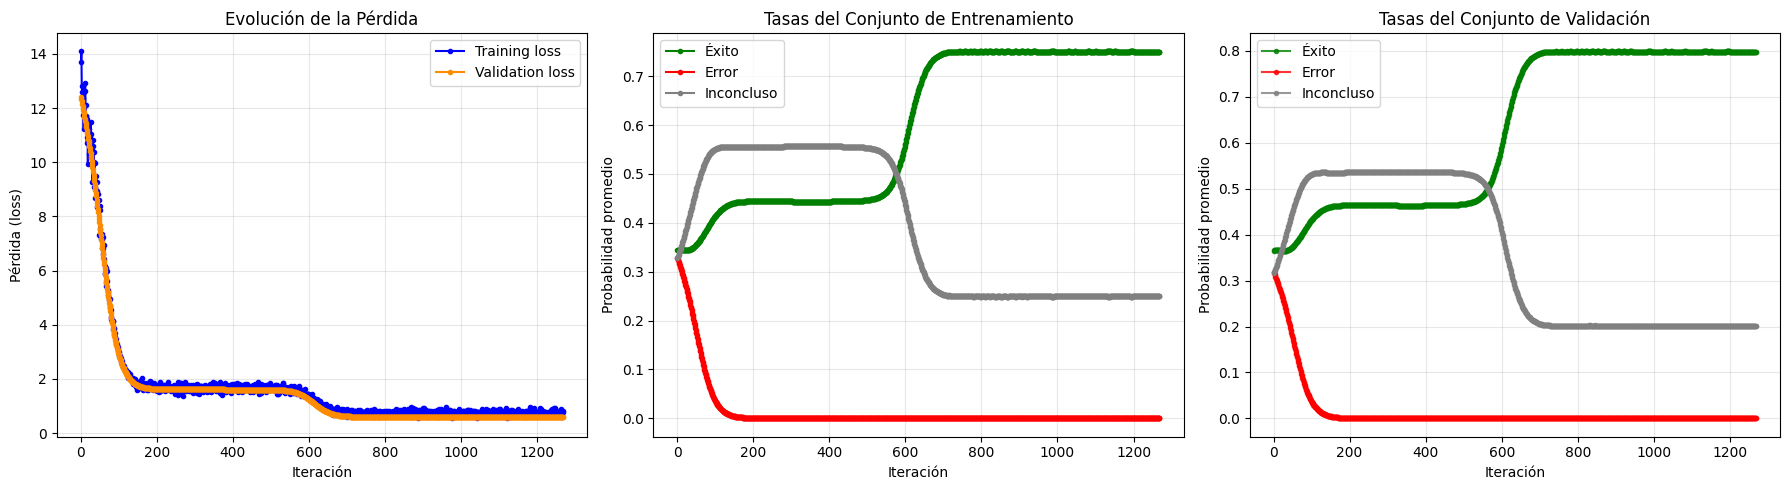

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

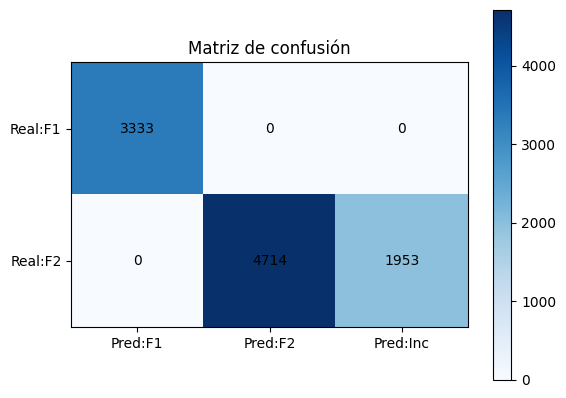

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
